In [1]:
from google.colab import files
api_token = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle competitions download -c dstl-satellite-imagery-feature-detection

 35% 5.00M/14.2M [00:00<00:00, 40.3MB/s]
100% 14.2M/14.2M [00:00<00:00, 69.8MB/s]
  0% 0.00/2.17k [00:00<?, ?B/s]
100% 2.17k/2.17k [00:00<00:00, 2.28MB/s]
100% 12.9G/12.9G [02:20<00:00, 139MB/s]
100% 12.9G/12.9G [02:20<00:00, 98.1MB/s]
100% 7.28G/7.30G [01:25<00:00, 73.4MB/s]
100% 7.30G/7.30G [01:25<00:00, 91.8MB/s]
 45% 5.00M/11.1M [00:00<00:00, 36.8MB/s]
100% 11.1M/11.1M [00:00<00:00, 53.6MB/s]
  0% 0.00/14.9k [00:00<?, ?B/s]
100% 14.9k/14.9k [00:00<00:00, 14.6MB/s]


In [4]:
import numpy as np
import pandas as pd
import cv2
import os
import random
import datetime
import matplotlib.pyplot as plt
from shapely.wkt import loads as wkt_loads
import tifffile as tiff

from keras import backend as K
# from sklearn.metrics import jaccard_similarity_score

from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import gc
import warnings
import zipfile
warnings.filterwarnings("ignore")
from keras.models import load_model
import tensorflow as tf
import random as rn
from tqdm import tqdm
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tqdm import tqdm

In [5]:
os.mkdir('/kaggle')
os.mkdir('/kaggle/data')
os.mkdir('/kaggle/msk')
os.mkdir('/kaggle/model_weights')
os.mkdir('/kaggle/subm')

In [6]:
TR = pd.read_csv('/content/grid_sizes.csv.zip')
T_W = pd.read_csv('/content/train_wkt_v4.csv.zip')


In [7]:
num_cls = 10
size = 160
smooth = 1e-12
TR = pd.read_csv('/content/train_wkt_v4.csv.zip')
GS = pd.read_csv('/content/grid_sizes.csv.zip', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)

#SF = pd.read_csv('/content/sample_submission.csv')
GS = GS.rename( columns={'Unnamed: 0':'ImageId'}) #rename 'ImageId'

In [8]:

def coordi_to_raster(coords, img_size, xmax, ymax):
    """
    converts coordinates(polygons) to raster(pixels).
    """
  
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / xmax
    yf = H1 / ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

def convert_contours(polygonList, raster_img_size, xmax, ymax):
    """
    Returns exterior and interior coords of the given multipolygon,
    which are then used to create image masks with multipolygon objects.
    """
    perim_list = []
    interior_list = []
    
    if polygonList is None:
        return None

    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = coordi_to_raster(perim, raster_img_size, xmax, ymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = coordi_to_raster(interior, raster_img_size, xmax, ymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def generate_mask_for_image_and_class(raster_size, image_id, class_type):

    """
    returns generated image_mask using img_size(raster_size), image_id and class_type.
    """
    xmax, ymax = GS[GS.ImageId == image_id].iloc[0, 1:].astype(float)

    df_image = TR[TR.ImageId == image_id]

    multipoly_def = df_image[df_image.ClassType == class_type].MultipolygonWKT
    polygonList = None

    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    
    contours = convert_contours(polygonList, raster_size, xmax, ymax)

    img_mask = np.zeros(raster_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, 1)
    cv2.fillPoly(img_mask, interior_list, 0)

    return img_mask

In [9]:
def adjust_contrast(bands, lower_percent=2, higher_percent=98):
    """
    to adjust the contrast of the image 
    bands is the image 
    """
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)
  

In [10]:
def resize_image(image):
  """
  to resize the image
  """
  if image.shape == (837,837,8):
    return image

  else:
    resized_data = resize(image, (837,837,8))
    imwrite('resized.tif', resized_data, planarconfig='CONTIG')
    return tiff.imread("resized.tif")


In [11]:
def prediction(id, model):

    """
    take inputs as image id and trained model 
    and returns predicted mask 
    """
  
    #Read 16-band image
    rgb_img = os.path.join( 'sixteen_band', '{}_M.tif'.format(id))      
    rgb_img = tiff.imread(rgb_img)
    img = np.rollaxis(rgb_img, 0, 3)


    #resize the image according to model architecture
    img = resize_image(img)

    #adjust the contrast of the image
    x = adjust_contrast(img)
    
    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((num_cls, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x
     
    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * size:(i + 1) * size, j * size:(j + 1) * size])
            
  
        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
       # x = 2 * np.transpose(line, (0, 1, 2, 3)) - 1

        tmp = model.predict(x, batch_size=4)
       # tmp = np.transpose(tmp,(0,3,1,2))

        for j in range(tmp.shape[0]):
            prd[:, i * size:(i + 1) * size, j * size:(j + 1) * size] = tmp[j]
     
    # thresholds for each class 
    trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(num_cls):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]

In [12]:
def M(image_id):
    # __author__ = amaia
    # https://www.kaggle.com/aamaia/dstl-satellite-imagery-feature-detection/rgb-using-m-bands-example
    zip_path = '/content/sixteen_band.zip'
    tgtImg = '{}_M.tif'.format(image_id)
    with zipfile.ZipFile(zip_path) as myzip:
        files_in_zip = myzip.namelist()
        for fname in files_in_zip:
            if fname.endswith(tgtImg):
                with myzip.open(fname) as myfile:
                    img = tiff.imread(myfile)
                    img = np.rollaxis(img, 0, 3)
                    return img
                
                

print ("let's combine all imgs together")
s = 835

X = np.zeros((5 * s, 5 * s, 8))
Y = np.zeros((5 * s, 5 * s, num_cls))  

ids = sorted(set(TR.ImageId))
print (len(ids))

for i in range(5):
    for j in range(5):
        id = ids[5 * i + j]

        rgb_img = M(id)
        img = adjust_contrast(rgb_img).copy()
        
        
        print (img.shape, id)
        X[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
        for z in range(num_cls):
            Y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]

np.save('/kaggle/data/X', X)
np.save('/kaggle/data/Y', Y)
print(X.shape)
print(Y.shape)


let's combine all imgs together
25
(837, 849, 8) 6010_1_2
(837, 849, 8) 6010_4_2
(837, 848, 8) 6010_4_4
(837, 848, 8) 6040_1_0
(837, 848, 8) 6040_1_3
(837, 848, 8) 6040_2_2
(837, 846, 8) 6040_4_4
(837, 851, 8) 6060_2_3
(838, 835, 8) 6070_2_3
(837, 848, 8) 6090_2_0
(837, 848, 8) 6100_1_3
(837, 848, 8) 6100_2_2
(837, 848, 8) 6100_2_3
(837, 849, 8) 6110_1_2
(837, 849, 8) 6110_3_1
(837, 849, 8) 6110_4_0
(837, 851, 8) 6120_2_0
(837, 851, 8) 6120_2_2
(837, 849, 8) 6140_1_2
(837, 849, 8) 6140_3_1
(837, 851, 8) 6150_2_3
(837, 848, 8) 6160_2_1
(837, 848, 8) 6170_0_4
(837, 848, 8) 6170_2_4
(837, 848, 8) 6170_4_1
(4175, 4175, 8)
(4175, 4175, 10)


In [13]:
X.shape,Y.shape

((4175, 4175, 8), (4175, 4175, 10))

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7f361ad8e690>)

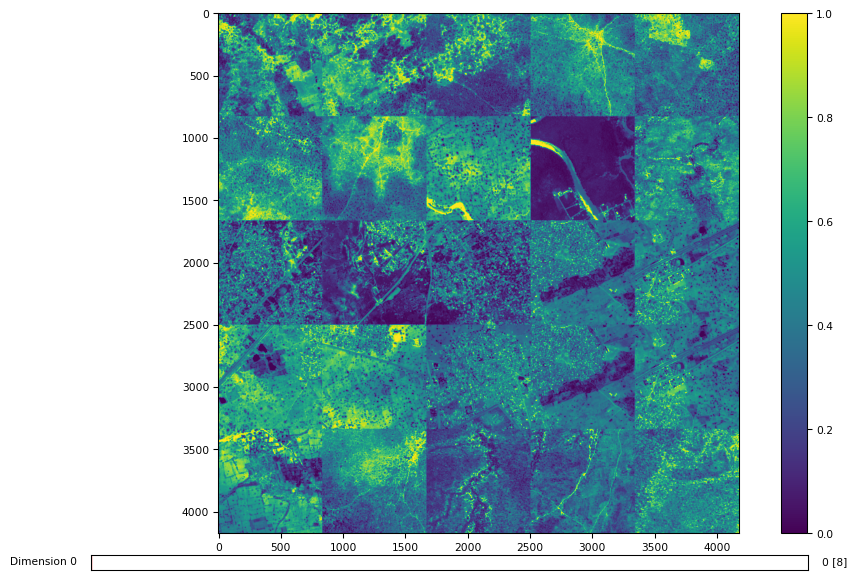

In [14]:
# Combining all 25 images into 1 image X
tiff.imshow(X)

(<Figure size 988.8x604.8 with 3 Axes>,
 <matplotlib.image.AxesImage at 0x7f361adced10>)

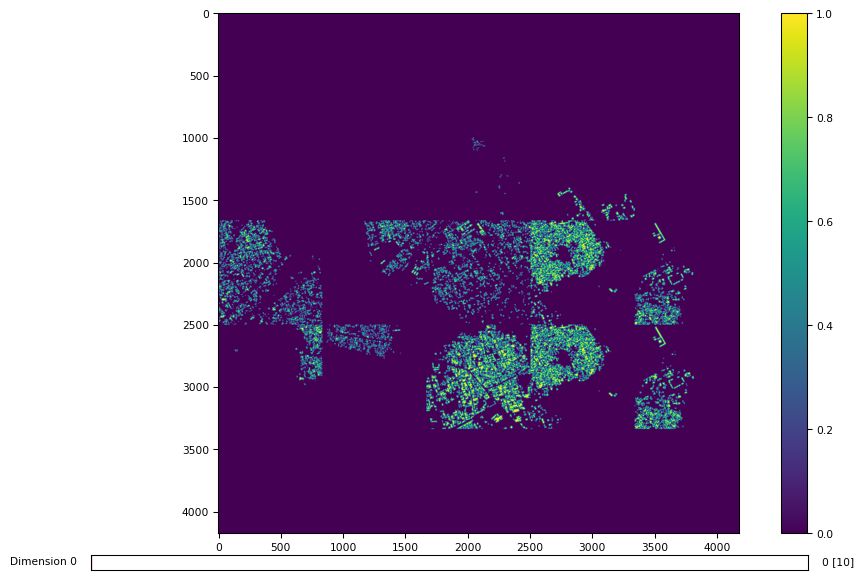

In [15]:
# All 25 masked image into 1 image.
tiff.imshow(Y)

In [16]:
# Augmentation

'''

1. Here the image size is (4175, 4175, 8).

2. For the x-axis I am subtracting 4175-160=4015 which I am storing in [xm].

3. Selecting random value between 0 to xm (4015) which I am storing in [xc].

4. Same for the y axis, where the random value is stored in [yc].


5. Now I take X image which is a combination of 25 images. 

6. Now I will extract a subsampled image of size [xc],[yc] where the values are generated randomly which is defined above (point 3).

7. The subsample image is stored in [im], same procedure for masked images store in [ms]. 

8. With [im] and [ms] I am applying augmentation techniques.

9. Here amt1 and amt2 defines the size of train and test data.


'''

def get_patches(img, msk, name1, name2, name3, name4, amt, aug=True):

    """
    returns image pathces(crops) of given image and mask
    patch_size = 160*160
    """

    random.seed(42)
    is2 = int(1.0 * size)
    print('is2',is2)


    xm, ym = img.shape[0] - is2, img.shape[1] - is2

    a, b , c, d = [], [], [], []

    # thresholds for each class to get patches
    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    
    xyz = np.ceil(amt*0.10).astype(int)
    
    amt1 = amt-xyz
    
    
    
    amt2 = xyz
    

   # to get augmented data
    for i in range(amt1):

        xc = random.randint(0, xm)
        yc = random.randint(0, ym)


        im = img[xc:xc + is2, yc:yc + is2]
        # print('im',im)
        # tiff.imshow(im)
        
        ms = msk[xc:xc + is2, yc:yc + is2]
        # print('ms',ms)
        # tiff.imshow(ms)



     
        for j in range(num_cls):
            sm = np.sum(ms[:, :, j])

            if 1.0 * sm / is2 ** 2 > tr[j]:
               
                #augmentation
                if aug:
                    
                    # reversing
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]

                    #flipping 
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]
                    rotation = np.random.randint(4) # 0, 1, 2, 3

                    #transpose & rotation
                    if random.uniform(0, 1) > 0.5:
                       im = np.rot90(im.transpose((1,0,2)), k=rotation)
                       ms = np.rot90(ms.transpose((1,0,2)), k=rotation)
                    
                    #rotation
                    if random.uniform(0, 1) > 0.5:
                      im = np.rot90(im, k=rotation)
                      ms = np.rot90(ms, k=rotation)
                    
                    #shearing 
                    if random.uniform(0, 1) > 0.5:
                       im = tf.keras.preprocessing.image.apply_affine_transform(im, shear=0)
                       im = tf.keras.preprocessing.image.apply_affine_transform(im, shear=0)
                                     
                
                im = im.astype(np.float16)
                ms = ms.astype(np.float16)
                
                
                np.save("/kaggle/{}/{}".format(name1, i),im)  
                np.save("/kaggle/{}/{}".format(name2, i),ms)  
               
                a.append("/kaggle/{}/{}.npy".format(name1, i))
                b.append("/kaggle/{}/{}.npy".format(name2, i))

    # to get non-augmented data
    for i in range(amt2):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)

        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]

        im = im.astype(np.float16)
        ms = ms.astype(np.float16)
                                  
        np.save("/kaggle/{}/{}".format(name3, i),im)  
        np.save("/kaggle/{}/{}".format(name4, i),ms)  
                
        c.append("/kaggle/{}/{}.npy".format(name3, i))
        d.append("/kaggle/{}/{}.npy".format(name4, i))

    
    print(len(a), len(b))
    print(len(c), len(d))
  
    return a+c, b+d

In [17]:
os.mkdir('/kaggle/x_tr_a')
os.mkdir('/kaggle/x_tr_na')
os.mkdir('/kaggle/y_tr_a')
os.mkdir('/kaggle/y_tr_na')

os.mkdir('/kaggle/x_val_a')
os.mkdir('/kaggle/x_val_na')
os.mkdir('/kaggle/y_val_a')
os.mkdir('/kaggle/y_val_na')

os.mkdir('/kaggle/x_test_a')
os.mkdir('/kaggle/x_test_na')
os.mkdir('/kaggle/y_test_a')
os.mkdir('/kaggle/y_test_na')

## split the data into train, val and test 

In [18]:
x_trn, y_trn = get_patches(X, Y, 'x_tr_a', 'y_tr_a', 'x_tr_na', 'y_tr_na', 20000, aug=True)

is2 160
6262 6262
2000 2000


In [19]:
x_val, y_val = get_patches(X, Y, 'x_val_a', 'y_val_a', 'x_val_na', 'y_val_na', 4000, aug=True)


is2 160
1246 1246
400 400


In [20]:
x_test, y_test = get_patches(X, Y, 'x_test_a', 'y_test_na', 'x_test_a', 'y_test_na', 4000, aug=True)


is2 160
1246 1246
400 400


# Data loder

In [21]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        #print(len(batch))
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size

class Dataset:
  
    def __init__(self, images_dir, mask_dir):
        
        self.ids = images_dir
        self.images_fps = images_dir
        self.masks_fps  = mask_dir
    
    def __getitem__(self, i):
        
        # read data
        image = np.load(self.images_fps[i]) 
        mask  = np.load(self.masks_fps[i])

          
        image = np.stack(image, axis=-1).astype('float')
        mask = np.stack(mask, axis=-1).astype('float')

        #image = np.transpose(image, (1,0,2)) 
        #mask = np.transpose(mask, (1,0,2)) 
    
        image = np.transpose(image, (0,2,1)) 
        mask = np.transpose(mask, (0,2,1)) 
  
        return image, mask
      
    def __len__(self):
        return len(self.ids)

In [22]:
train_dataset = Dataset(x_trn, y_trn)
train_dataloader = Dataloder(train_dataset, batch_size=8)
val_dataset = Dataset(x_val, y_val)
val_dataloader = Dataloder(val_dataset, batch_size=8)


In [23]:
def jaccard_coef(y_true, y_pred):
    """
    Jaccard Index: Intersection over Union.
    J(A,B) = |A∩B| / |A∪B| 
         = |A∩B| / |A|+|B|-|A∩B|
    """
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    total = K.sum(y_true + y_pred, axis=[0, -1, -2])
    union = total - intersection

    jac = (intersection + smooth) / (union+ smooth)

    return K.mean(jac)

In [24]:
size
Input(shape=(size, size, 8))



<KerasTensor: shape=(None, 160, 160, 8) dtype=float32 (created by layer 'input_1')>

# SEGNet

In [25]:
##fixing numpy RS
np.random.seed(42)
# from keras import Adam

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)

def SegNet():
    
    tf.random.set_seed(32)
    classes= 10
    img_input = Input(shape=(size, size, 8))
    x = img_input
    

    # Encoder 
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 23))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',  kernel_initializer = tf.keras.initializers.he_normal(seed= 43))(x)
   # x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    # x = Dropout(0.1)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 32))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 41))(x)
   # x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 33))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    # x = Dropout(0.1)(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 35))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 54))(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 39))(x)
    x = BatchNormalization()(x)
    
    # x = Dropout(0.1)(x)
    
    #Decoder
    
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 45))(x)
   # x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 41))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 49))(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.1)(x)
      
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 18))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 21))(x)
    x = BatchNormalization()(x)
    x = Conv2D(classes, kernel_size=3, activation='relu', padding='same', kernel_initializer = tf.keras.initializers.he_normal(seed= 16))(x)
    # x = Dropout(0.1)(x)
  
    x = Activation("softmax")(x)
    
    model = Model(img_input, x)
  
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),loss='binary_crossentropy', metrics=[jaccard_coef])
    return model

In [26]:
#https://towardsdatascience.com/neural-network-with-tensorflow-how-to-stop-training-using-callback-5c8d575c18a9

ACCURACY_THRESHOLD=0.5
class myCallback(tf.keras.callbacks.Callback): 
    
    def on_epoch_end(self, epoch, logs={}): 
        if (logs.get('val_jaccard_coef') > ACCURACY_THRESHOLD) and (logs.get('jaccard_coef') > ACCURACY_THRESHOLD):   #and ((logs.get('accuracy')-logs.get('val_accuracy'))<=5):
          print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
          self.model.stop_training = True

stop = myCallback()

In [27]:
filepath="weights-{epoch:02d}-{val_jaccard_coef:.4f}.hdf5"

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto')

In [28]:
call_list = [checkpoint, stop]

In [29]:
model = SegNet()

In [30]:
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 8)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 64)      4672      
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 128)       73856 

In [31]:
epo=250
history_segnet = model.fit(train_dataloader, 
                              steps_per_epoch=len(train_dataloader),
                              epochs=epo,
                              validation_data=val_dataloader, 
                              callbacks=call_list
                              )

Epoch 1/250
1032/1032 [==============================] - ETA: 0s - loss: 0.6904 - jaccard_coef: 0.1224
Epoch 00001: val_loss improved from inf to 0.67637, saving model to weights-01-0.1241.hdf5
1032/1032 [==============================] - 153s 130ms/step - loss: 0.6904 - jaccard_coef: 0.1224 - val_loss: 0.6764 - val_jaccard_coef: 0.1241
Epoch 2/250
1032/1032 [==============================] - ETA: 0s - loss: 0.6748 - jaccard_coef: 0.1893
Epoch 00002: val_loss improved from 0.67637 to 0.67068, saving model to weights-02-0.2198.hdf5
1032/1032 [==============================] - 132s 128ms/step - loss: 0.6748 - jaccard_coef: 0.1893 - val_loss: 0.6707 - val_jaccard_coef: 0.2198
Epoch 3/250
1032/1032 [==============================] - ETA: 0s - loss: 0.6706 - jaccard_coef: 0.2365
Epoch 00003: val_loss improved from 0.67068 to 0.66858, saving model to weights-03-0.2343.hdf5
1032/1032 [==============================] - 132s 128ms/step - loss: 0.6706 - jaccard_coef: 0.2365 - val_loss: 0.6686 - 

In [32]:
test_dataset = Dataset(x_test, y_test)
test_dataloader = Dataloder(test_dataset, batch_size=1)

In [33]:
Score= []
for i in tqdm(range(len(test_dataloader))):
   pred_msk = model.predict(test_dataloader[i][0])
   score = jaccard_coef(test_dataloader[i][1], pred_msk)
   Score.append(score)

100%|██████████| 1646/1646 [02:16<00:00, 12.06it/s]


In [34]:

score = sum(Score)/len(test_dataloader)
print("The score on test data is", score.numpy())

The score on test data is 0.4502803616556966


## Error Analysis

In [35]:

total_x = x_trn + x_val + x_test
total_y = y_trn + y_val+ y_test

In [36]:
total_dataset = Dataset(total_x, total_y)
total_dataloader = Dataloder(total_dataset, batch_size=1)

In [55]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


In [56]:
Score= []
very_low_jaccard=[]
medium_jaccard= []
very_high_jaccard= []

for i in tqdm(range(len(total_dataloader))):

   pred_msk = loaded_model.predict(total_dataloader[i][0])
   score = jaccard_coef(total_dataloader[i][1], pred_msk)
   
   if score>0 and score <=0.20:
      very_low_jaccard.append(i)

   elif score>0.20 and score <=0.70:
      medium_jaccard.append(i)
   
   elif score>0.70 and score <=1:
      very_high_jaccard.append(i)

100%|██████████| 11554/11554 [15:31<00:00, 12.40it/s]


In [57]:

Very_low_jaccard_x = []
Medium_jaccard_x = []
Very_high_jaccard_x = []

Very_low_jaccard_y = []
Medium_jaccard_y = []
Very_high_jaccard_y = []


# Appending original images based on jaccard score
for i in very_low_jaccard:
   Very_low_jaccard_x.append(total_x[i])
for i in medium_jaccard:
   Medium_jaccard_x.append(total_x[i])
for i in very_high_jaccard:
   Very_high_jaccard_x.append(total_x[i])      


# Appending Mask images based on jaccard score
for i in very_low_jaccard:
   Very_low_jaccard_y.append(total_y[i])
for i in medium_jaccard:
   Medium_jaccard_y.append(total_y[i])
for i in very_high_jaccard:
   Very_high_jaccard_y.append(total_y[i])

In [58]:
np.save("vljx", Very_low_jaccard_x)
np.save("vljy", Very_low_jaccard_y)

In [59]:

vljx = np.load("vljx.npy")
vljy = np.load("vljy.npy")

In [60]:
len(vljx)
vljx[1]

'/kaggle/x_tr_a/18.npy'

### Observations

In [61]:

print("minimum value in an image",np.amin(np.load(vljx[0])))
print("maximum value in an image",np.amax(np.load(vljx[0])))

minimum value in an image 0.0
maximum value in an image 1.0


In [62]:
threshold = 0.4
Sum = []

for i in tqdm(range(25)):
   a = np.load(vljx[i])
   im= []
   for j in range(8):
     im.append(np.count_nonzero(np.less(a[:,:,j], threshold))) 
   x = sum(im)
   Sum.append(x)  
percentage = (sum(Sum)/(160*160*8*25))*100

100%|██████████| 25/25 [00:00<00:00, 159.37it/s]


Observations

In [63]:

def plot_image(image_id):

  m = np.load(vljx[image_id])
  m = adjust_contrast(m)
  img = np.zeros((m.shape[0],m.shape[1],3))
  img[:,:,0] = m[:,:,4] #red
  img[:,:,1] = m[:,:,2] #green
  img[:,:,2] = m[:,:,1] #blue
  #plt.figure(figsize=(7,7))
  tiff.imshow(img, interpolation='nearest')
  # plt.show()

In [64]:
def plot_mask(mask_id):
  m = np.load(vljy[i])
  m = adjust_contrast(m)
  img = np.zeros((m.shape[0],m.shape[1],3)) 
  img[:,:,0] = m[:,:,4] #red
  img[:,:,1] = m[:,:,2] #green
  img[:,:,2] = m[:,:,1] #blue
  #plt.figure(figsize=(7,7))
  tiff.imshow(img, interpolation='nearest')
  # plt.show()

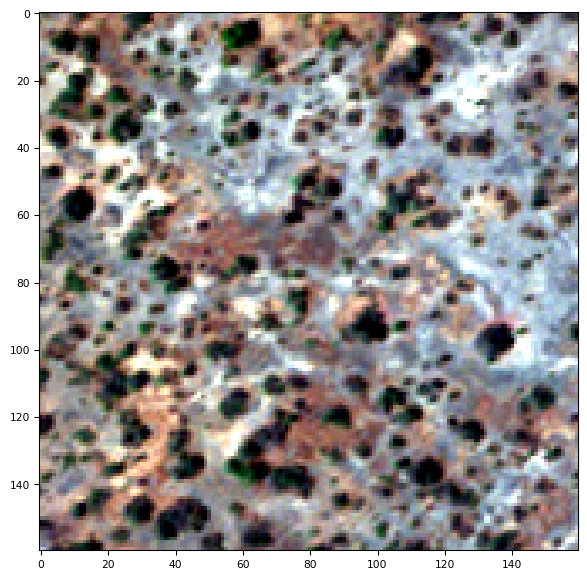

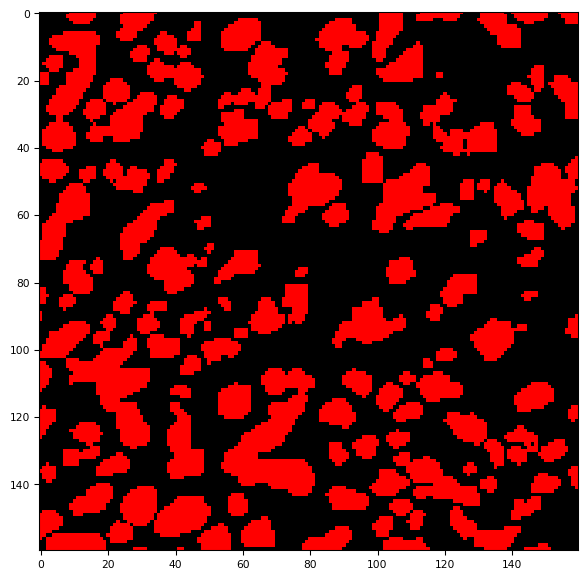

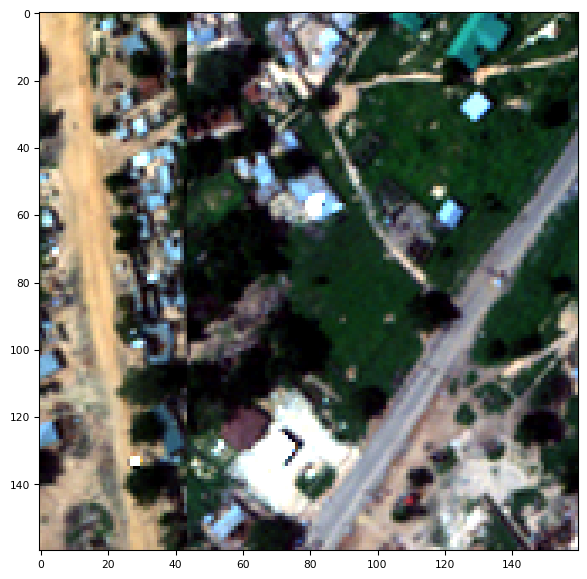

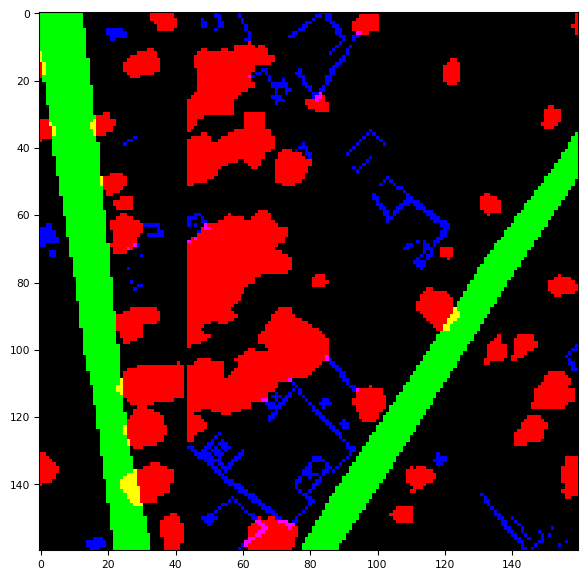

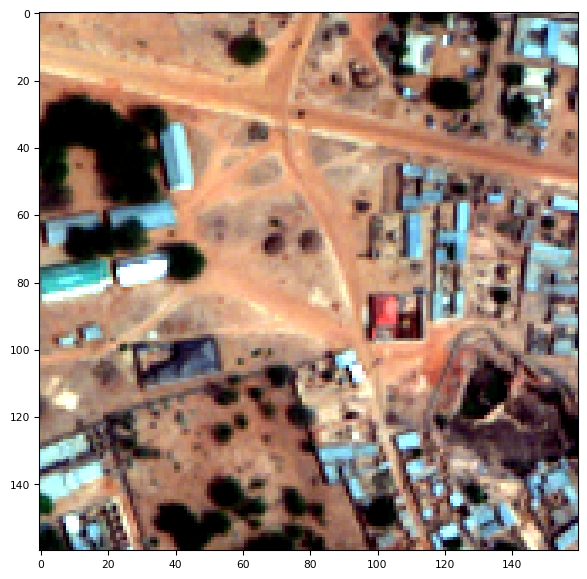

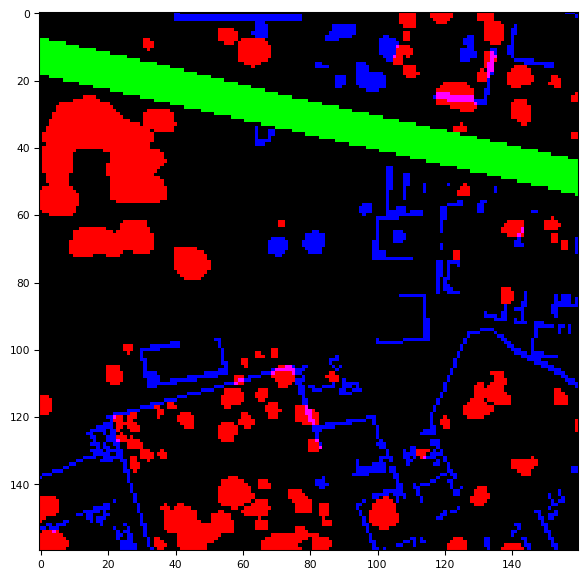

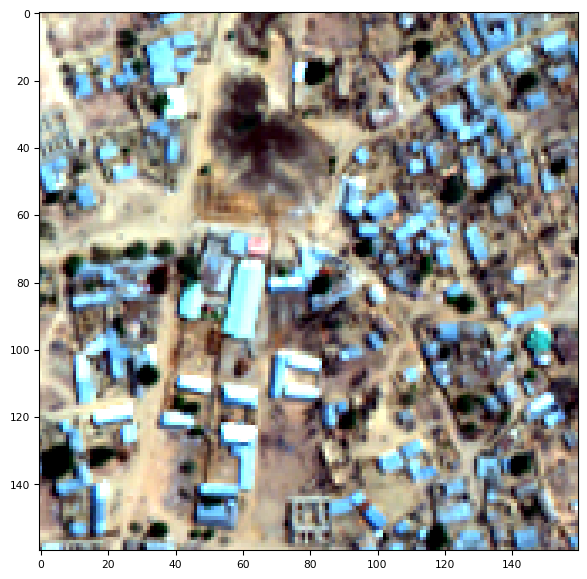

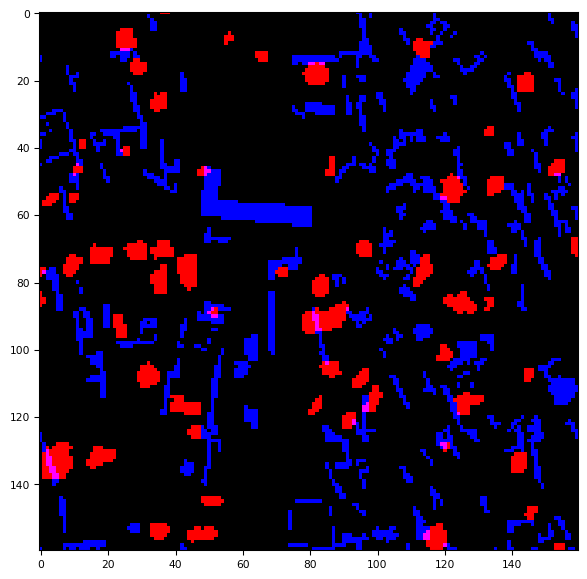

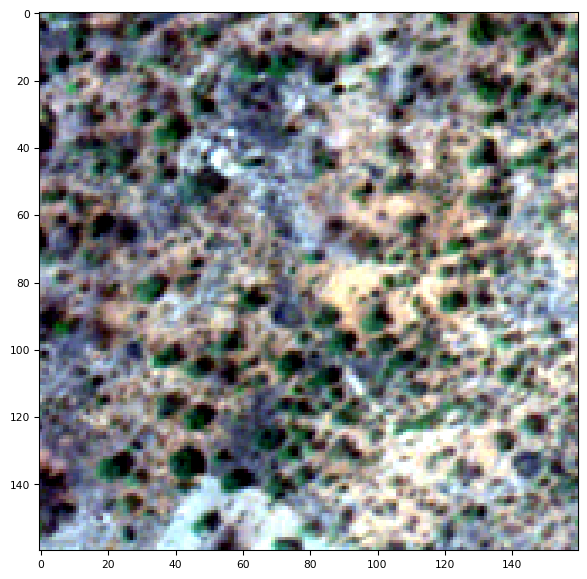

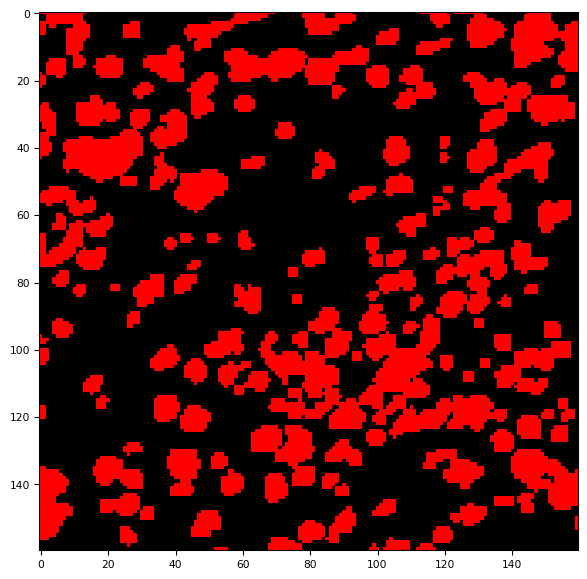

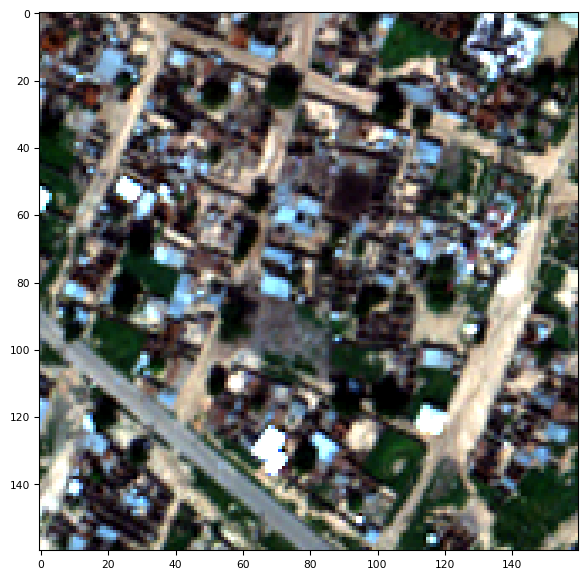

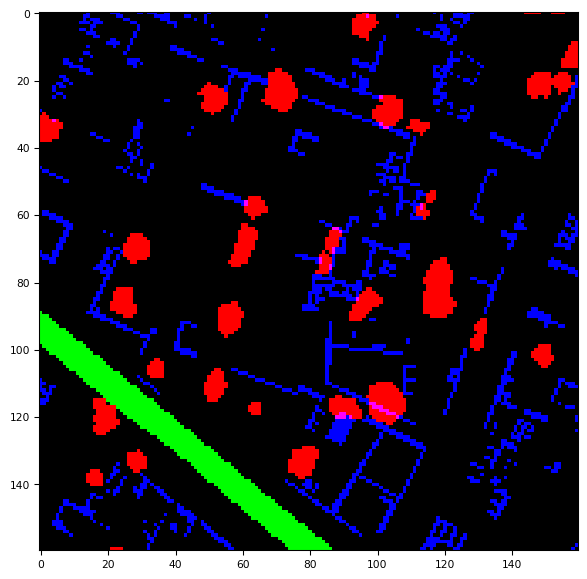

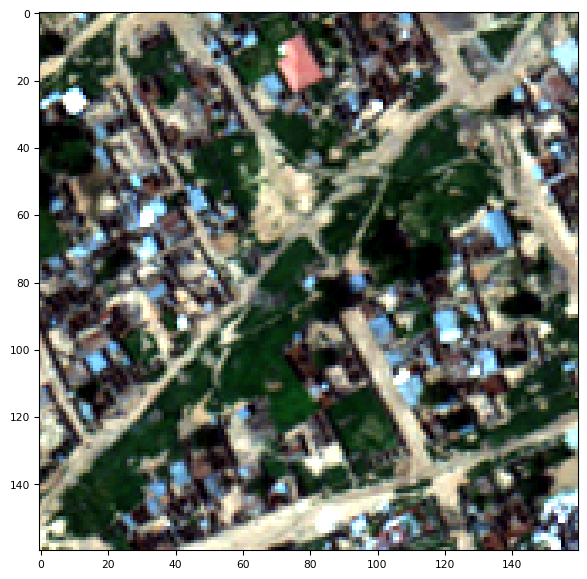

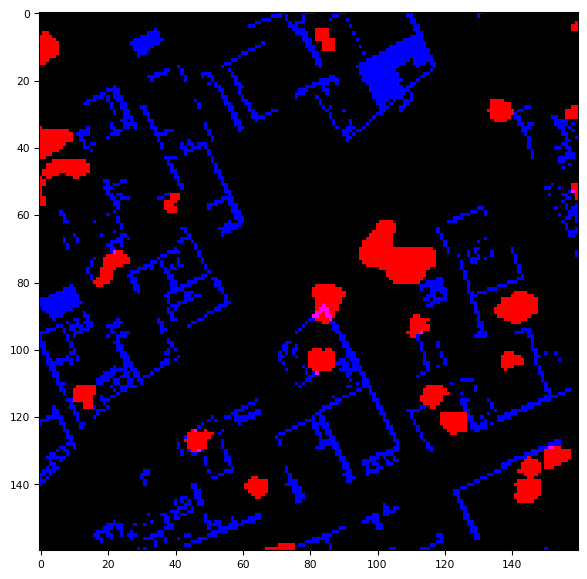

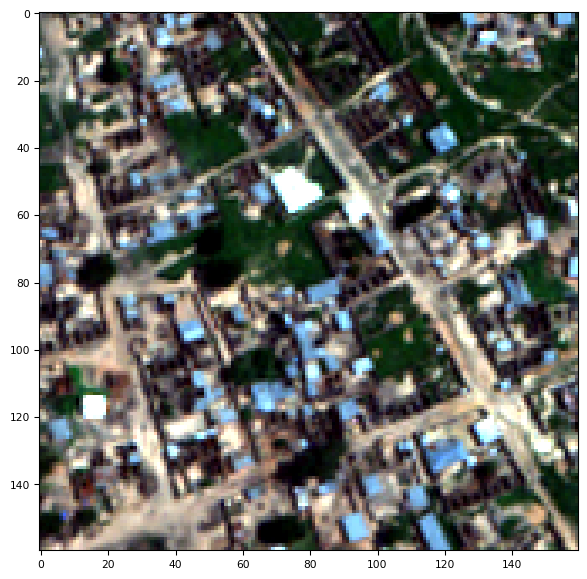

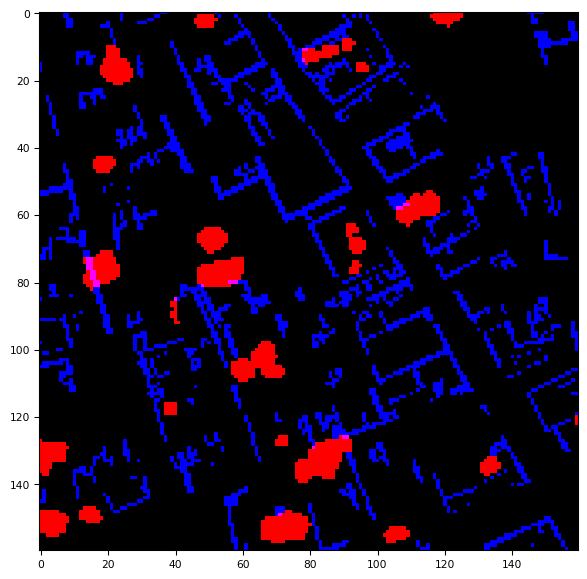

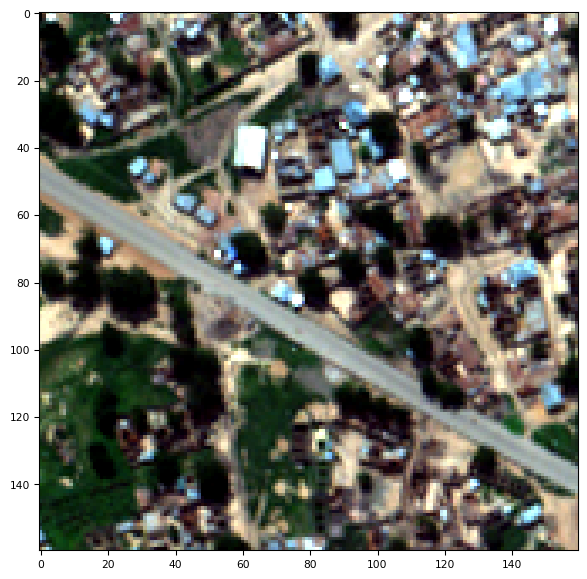

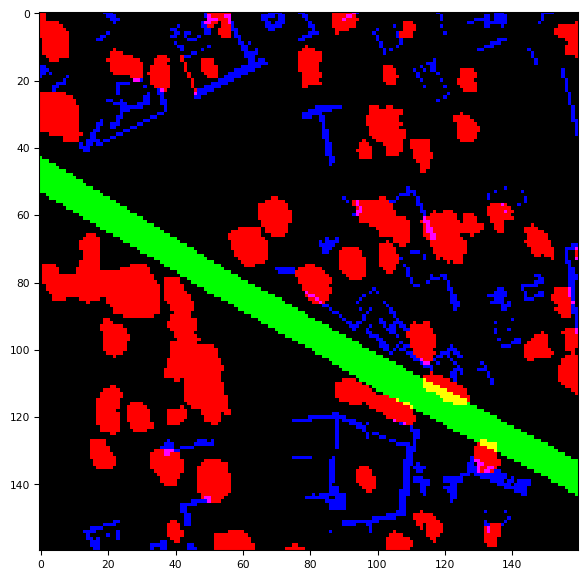

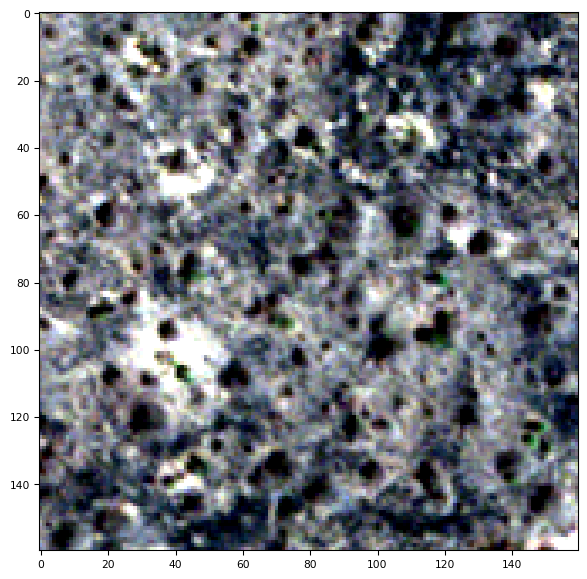

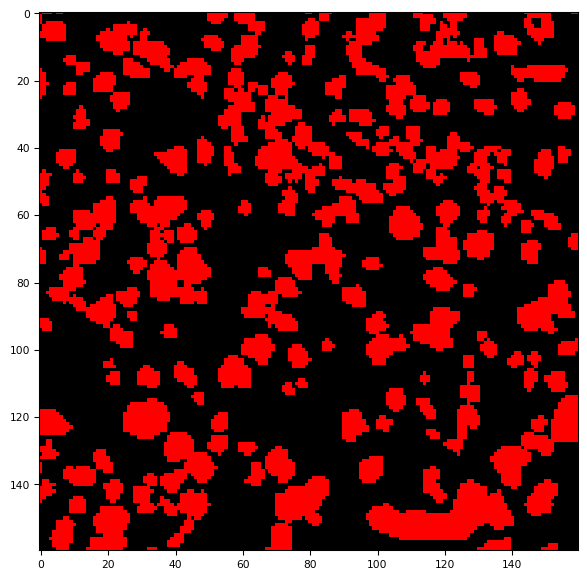

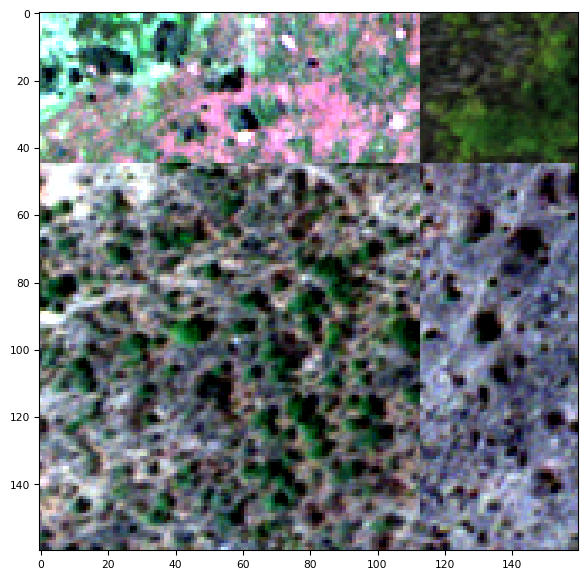

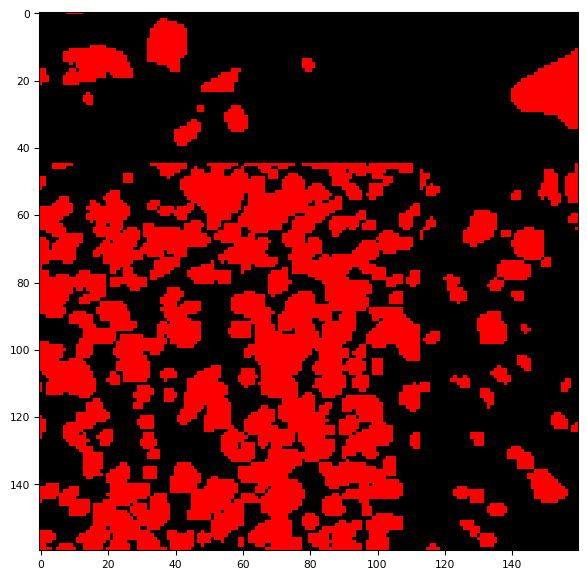

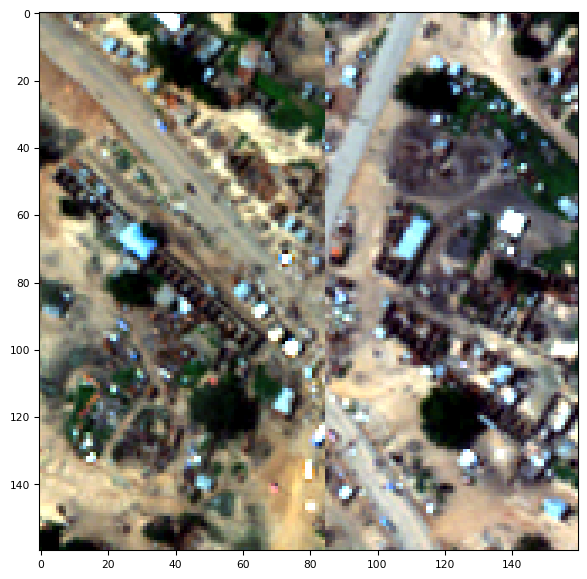

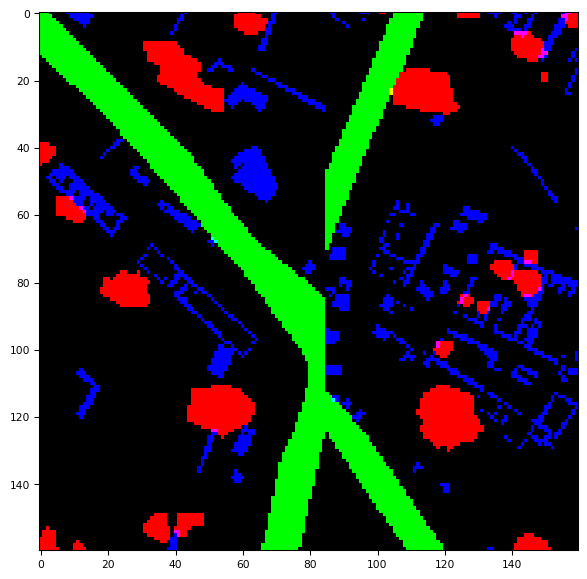

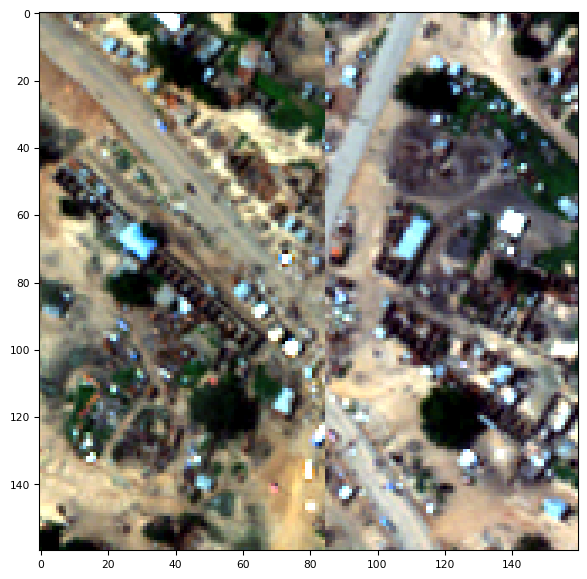

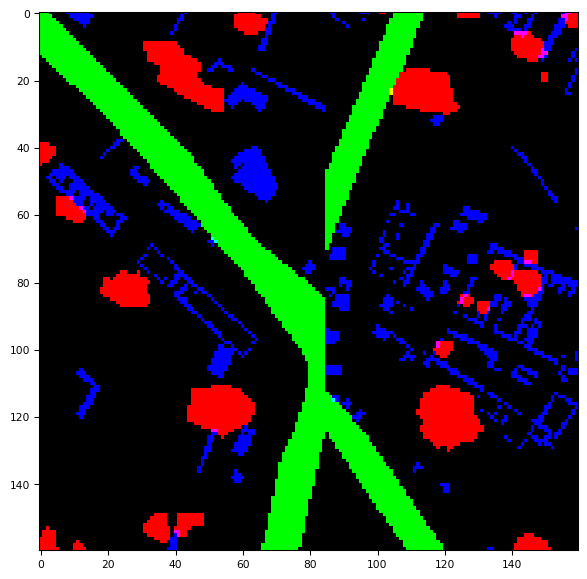

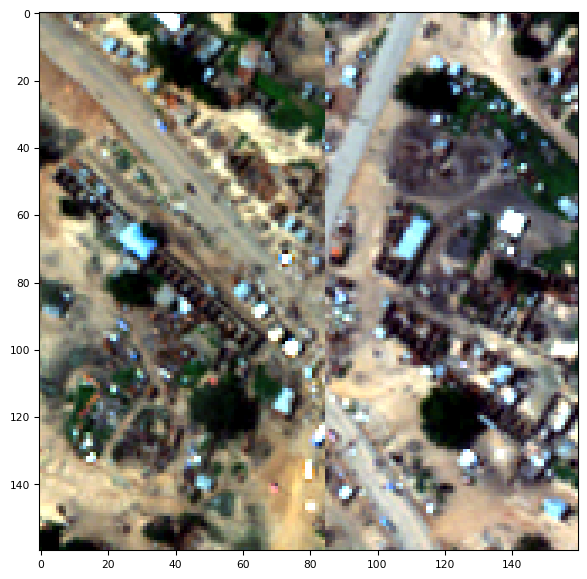

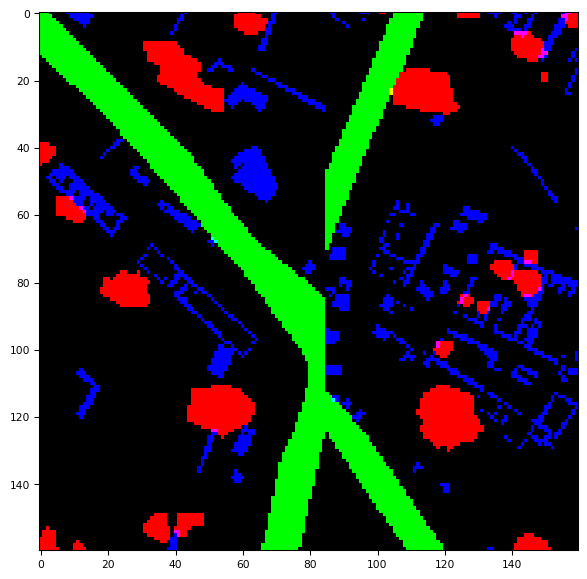

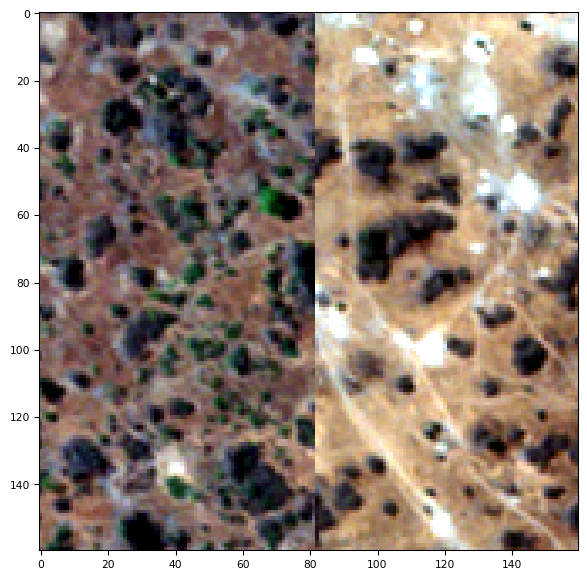

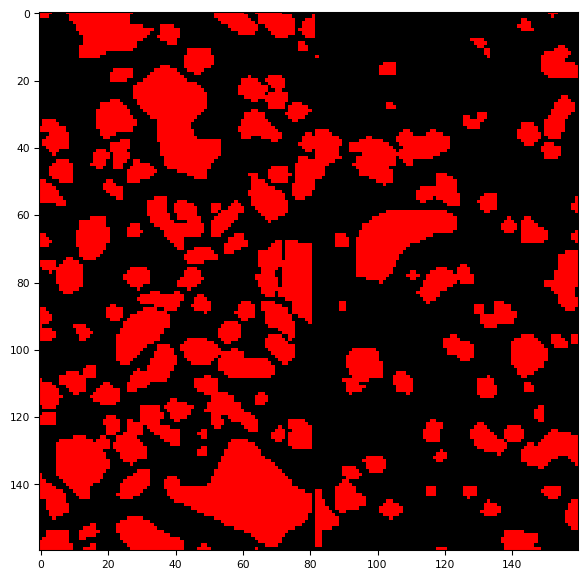

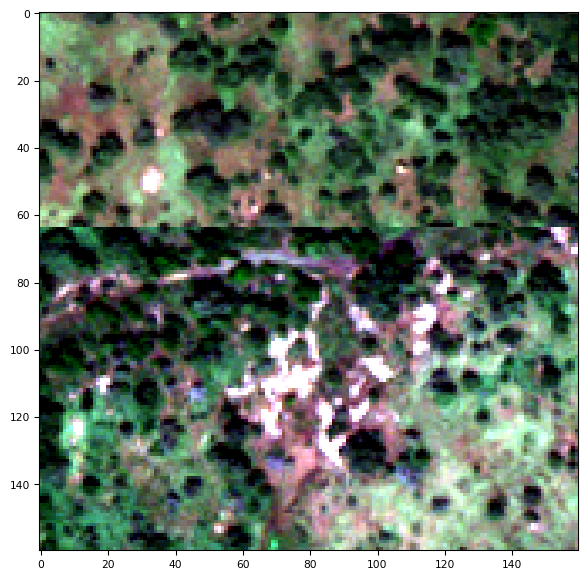

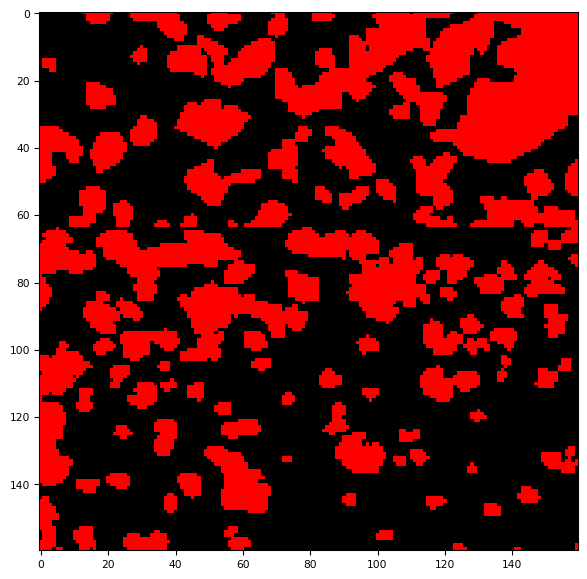

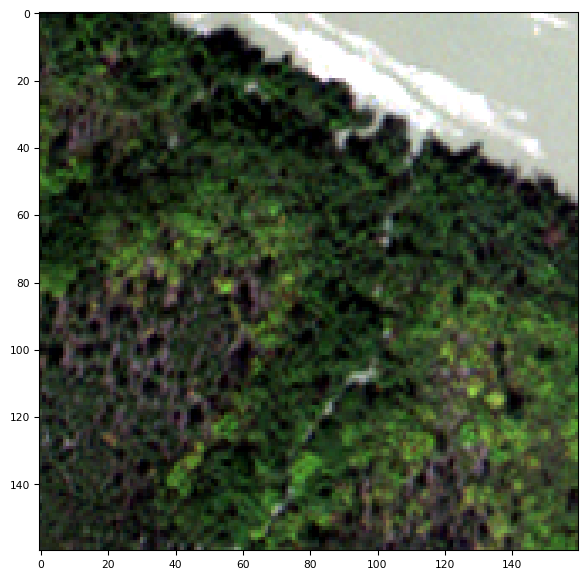

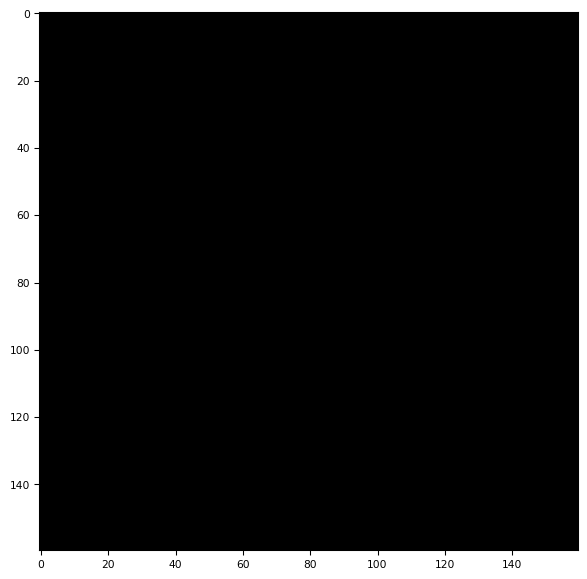

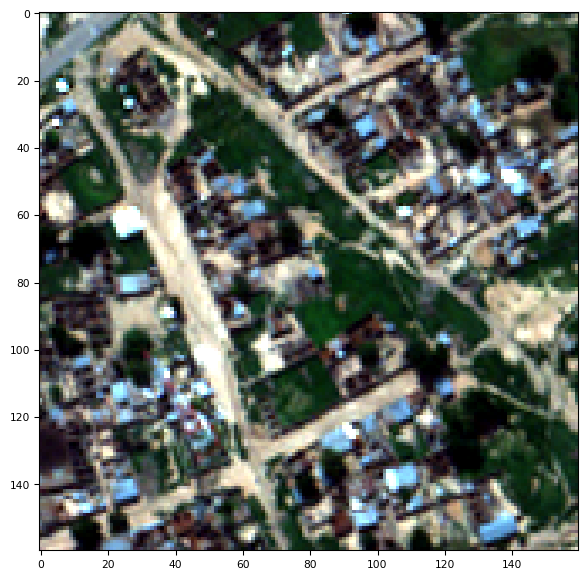

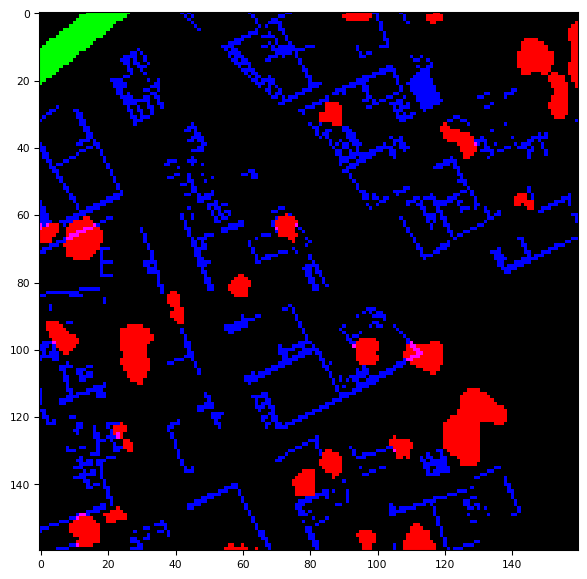

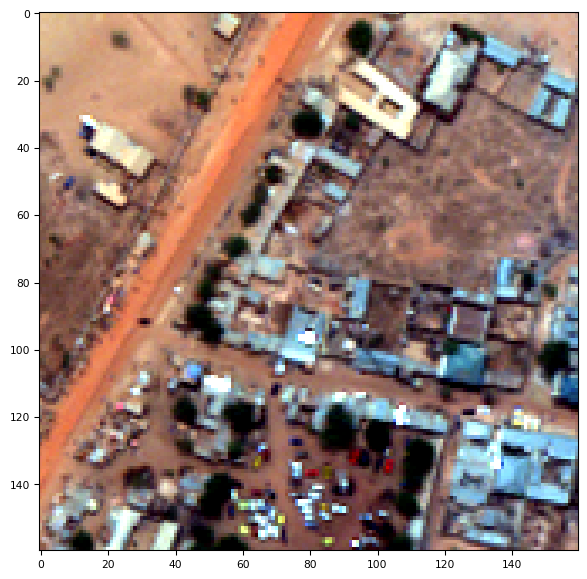

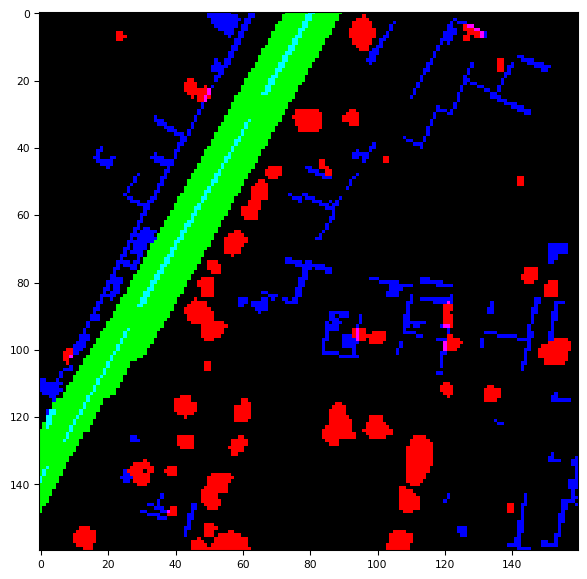

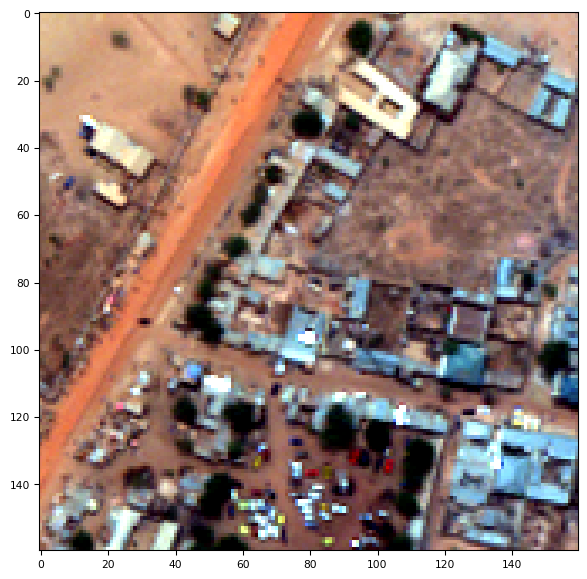

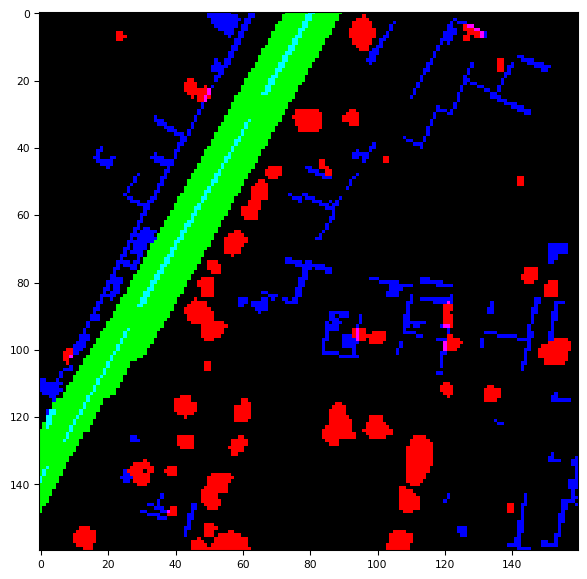

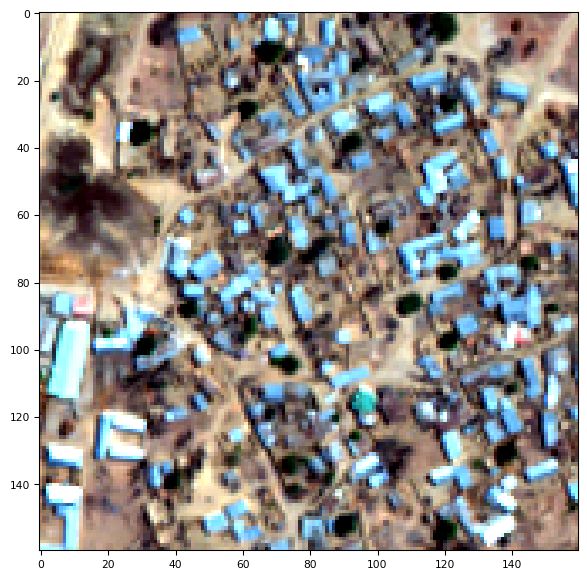

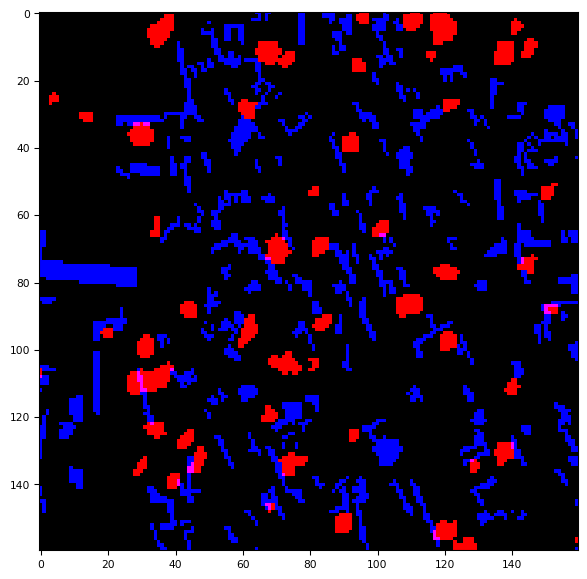

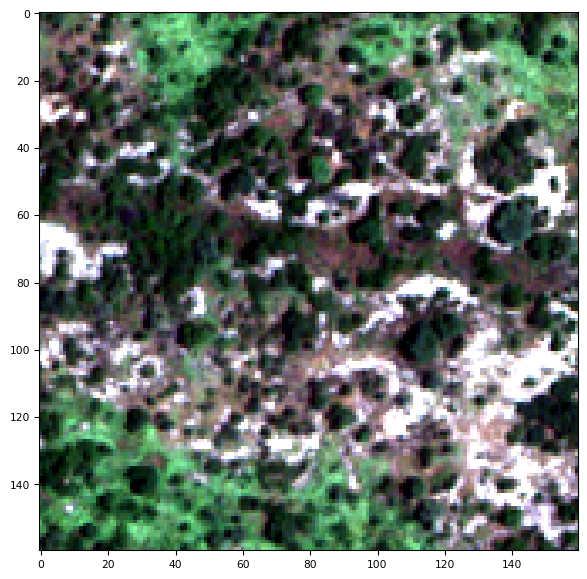

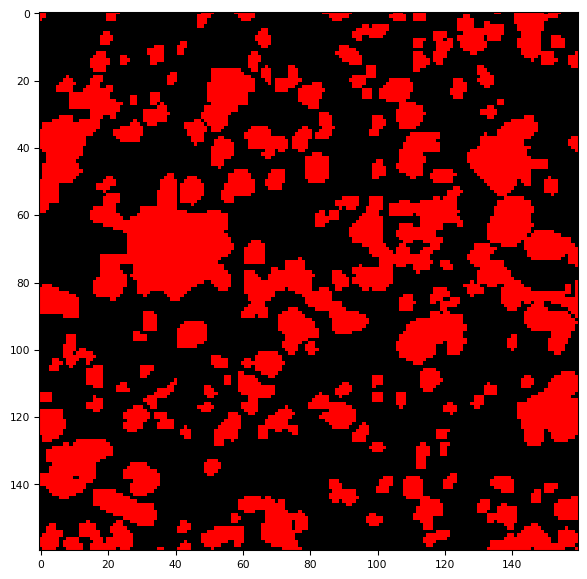

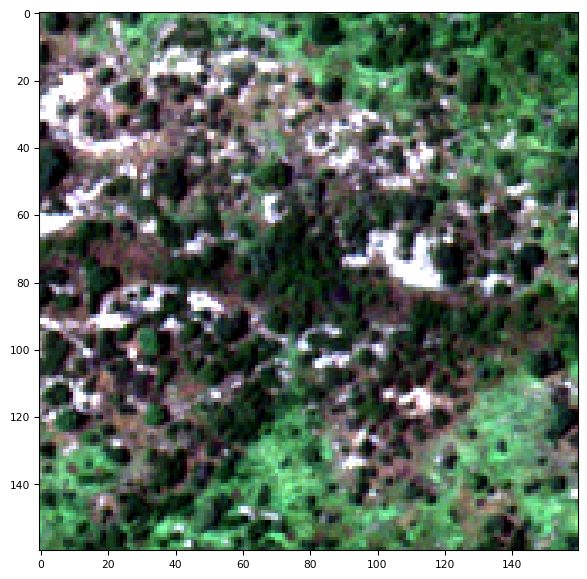

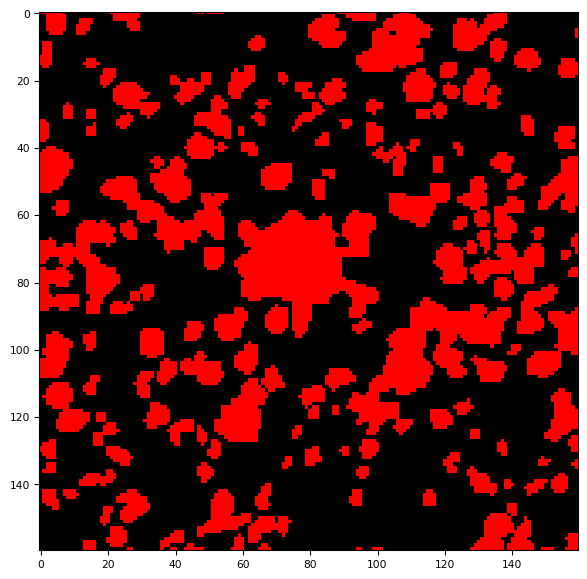

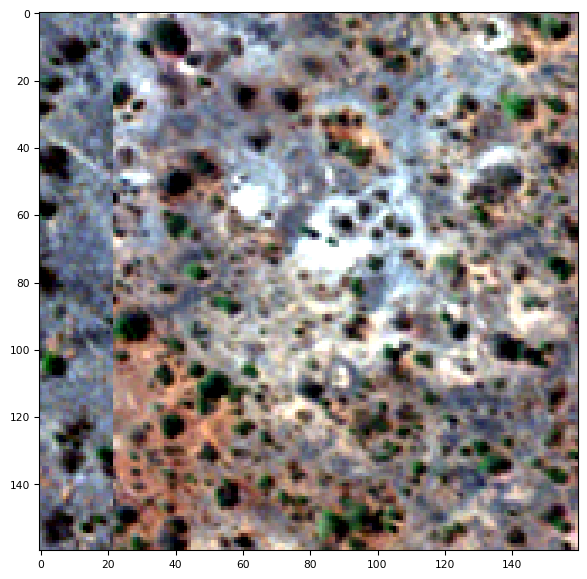

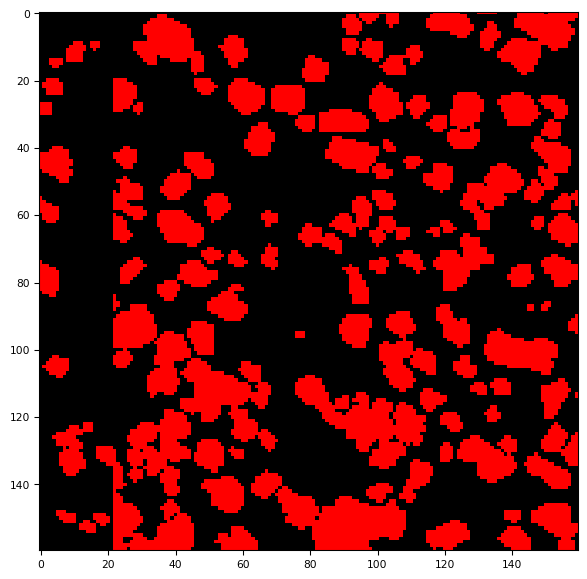

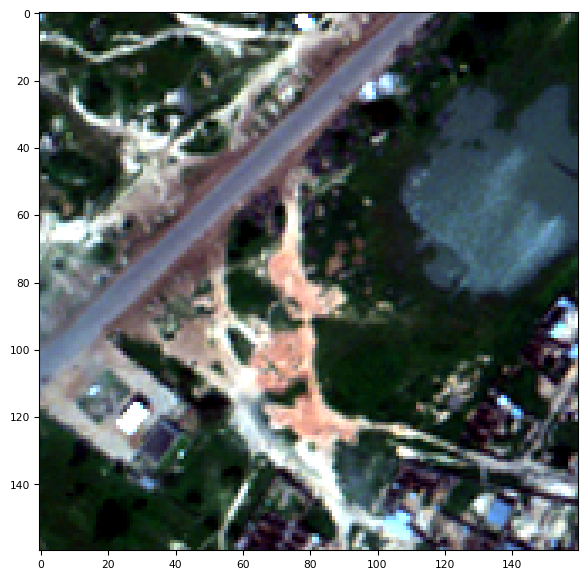

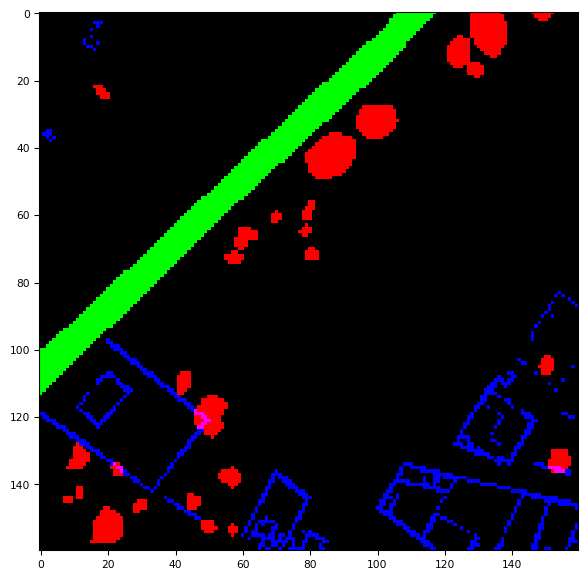

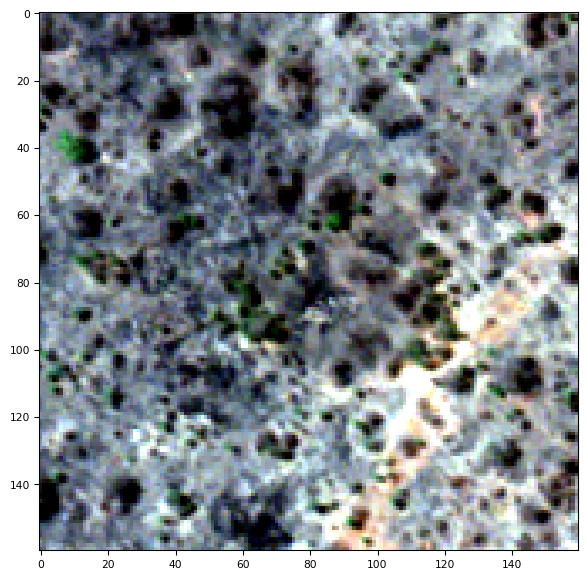

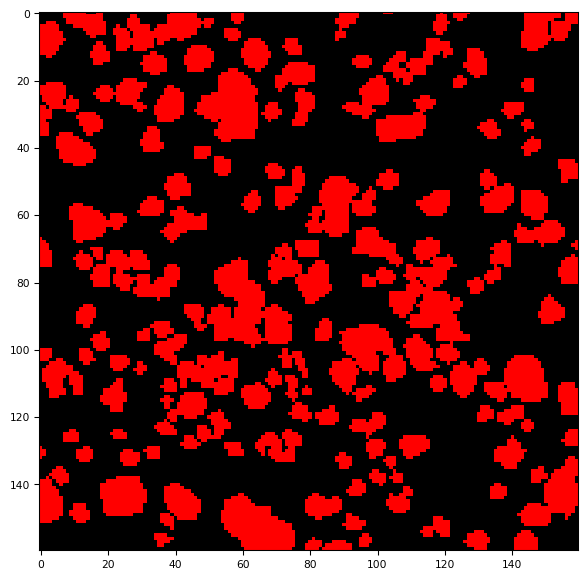

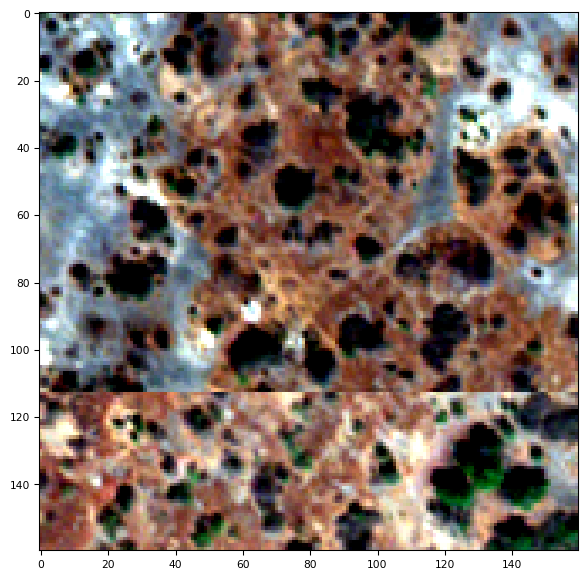

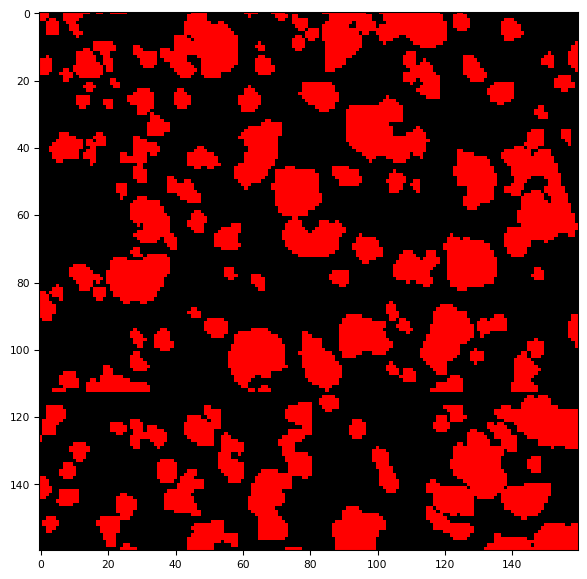

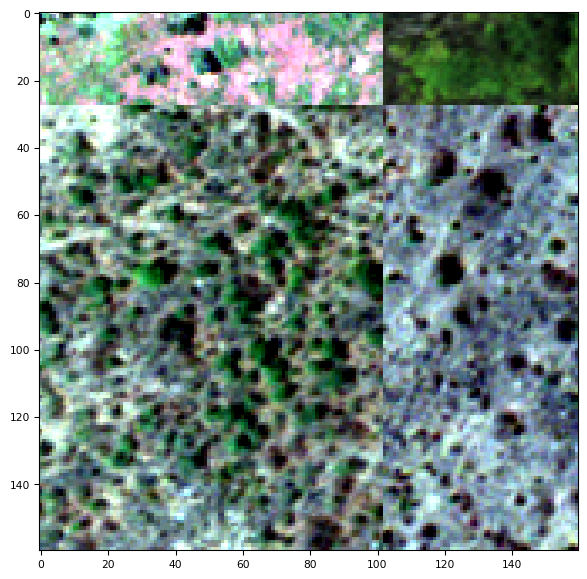

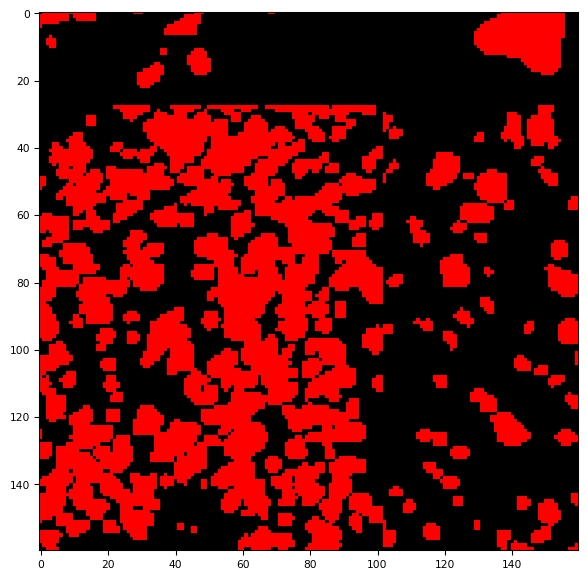

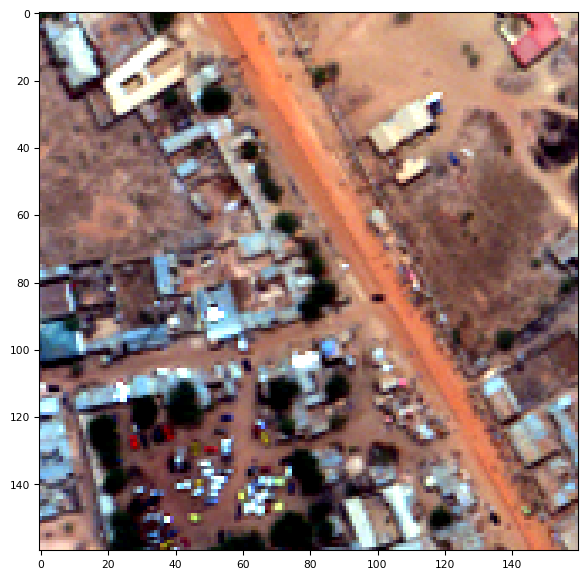

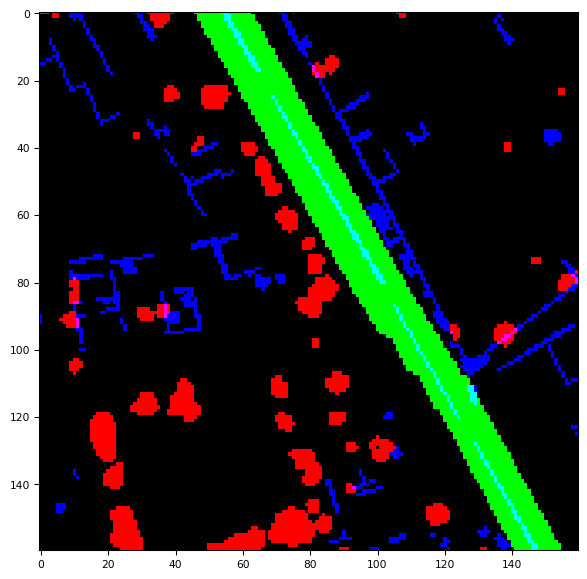

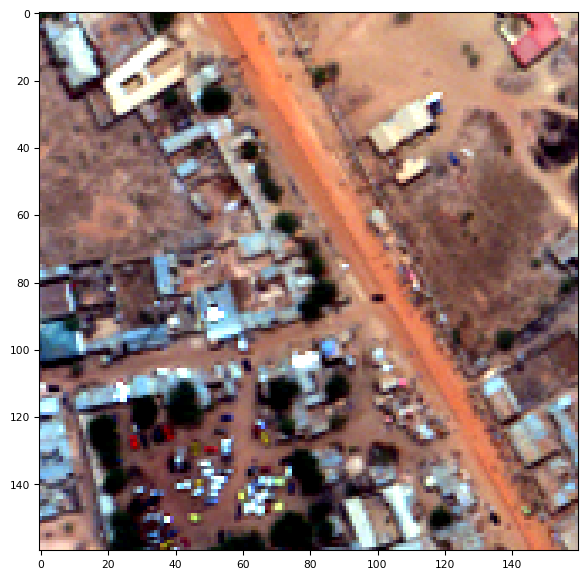

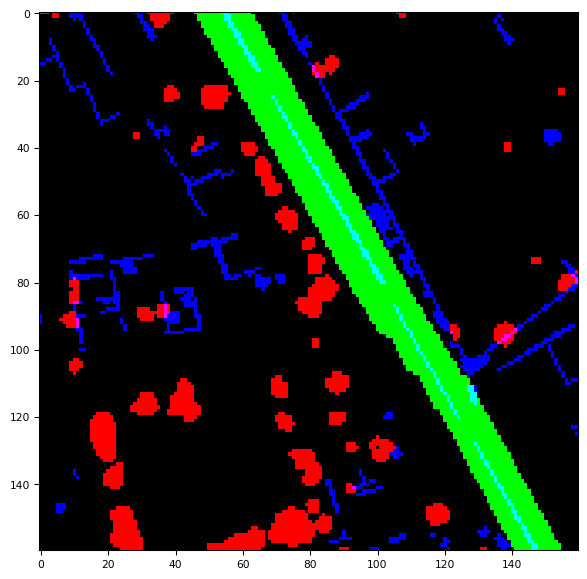

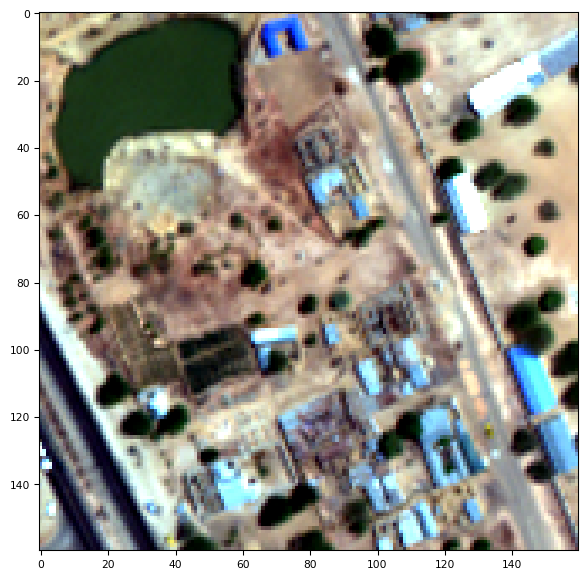

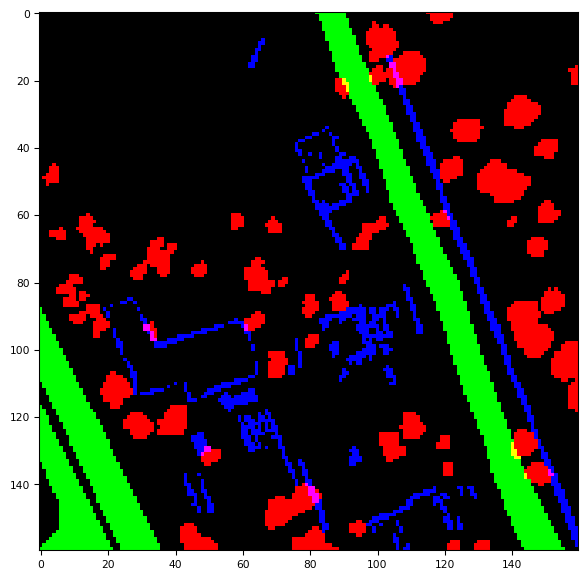

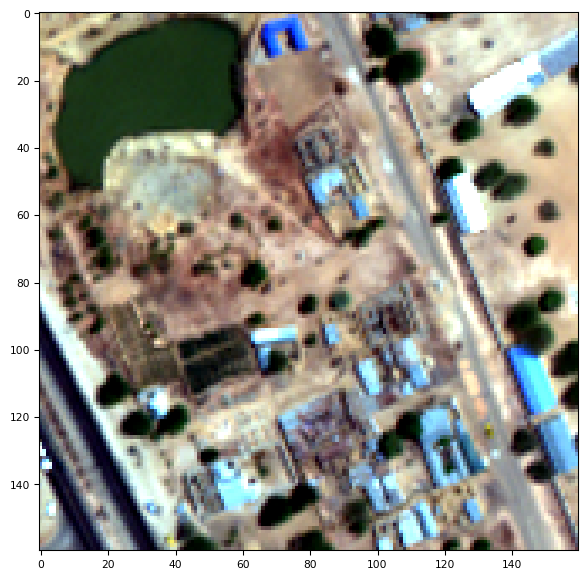

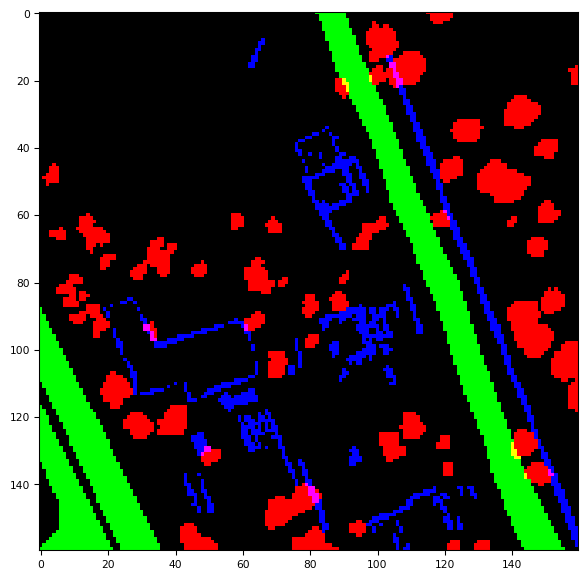

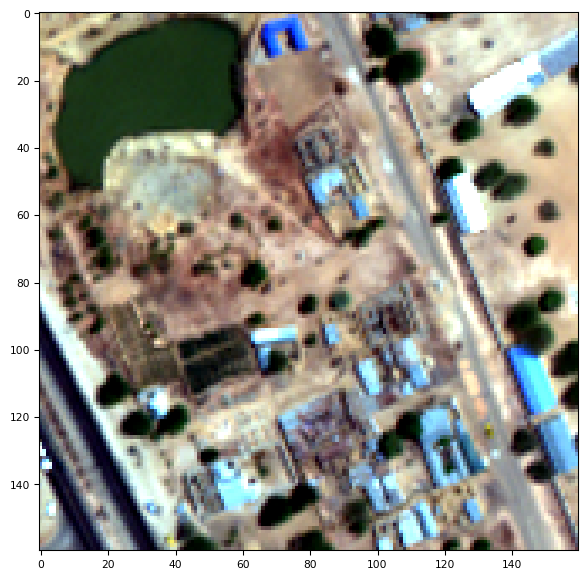

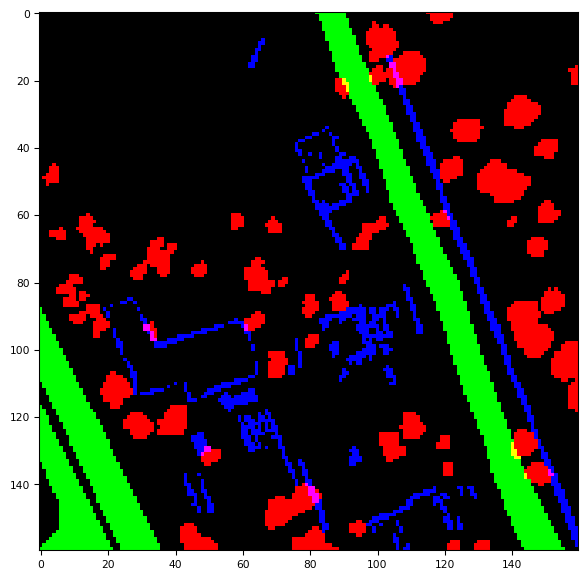

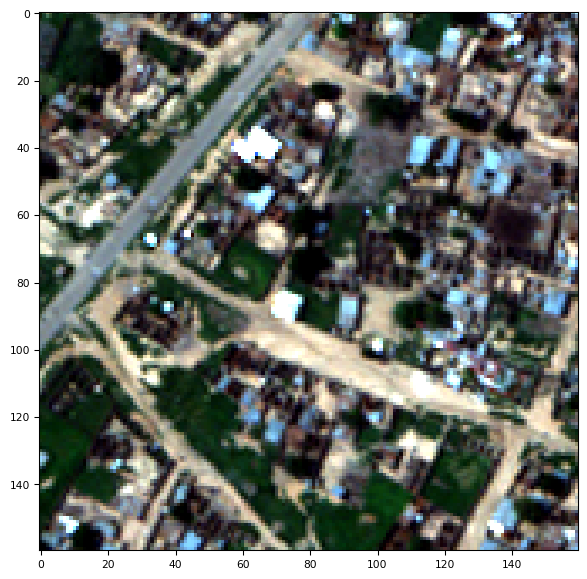

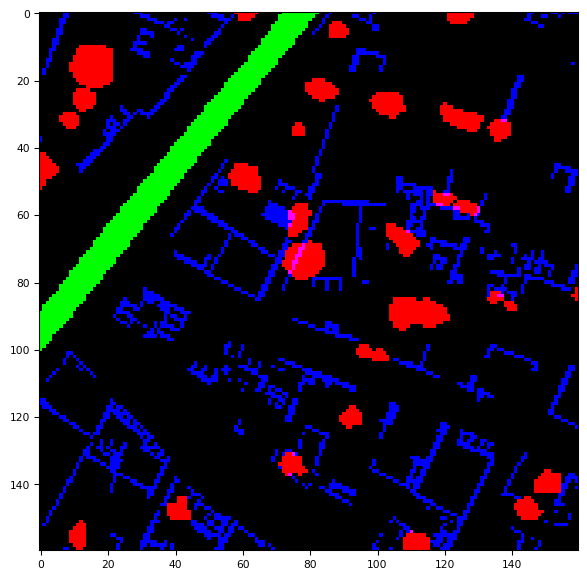

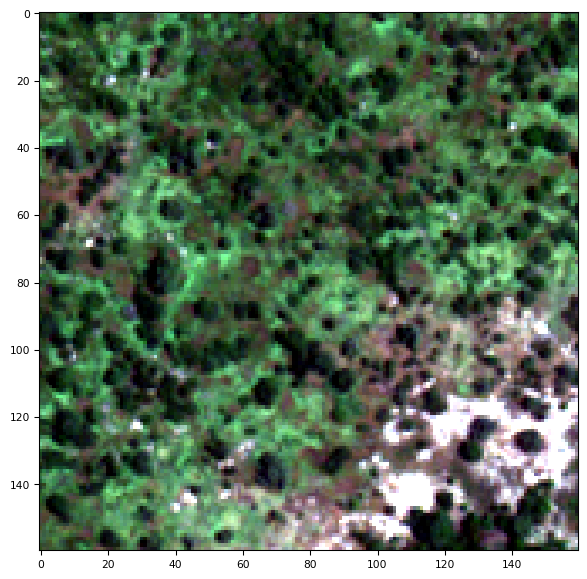

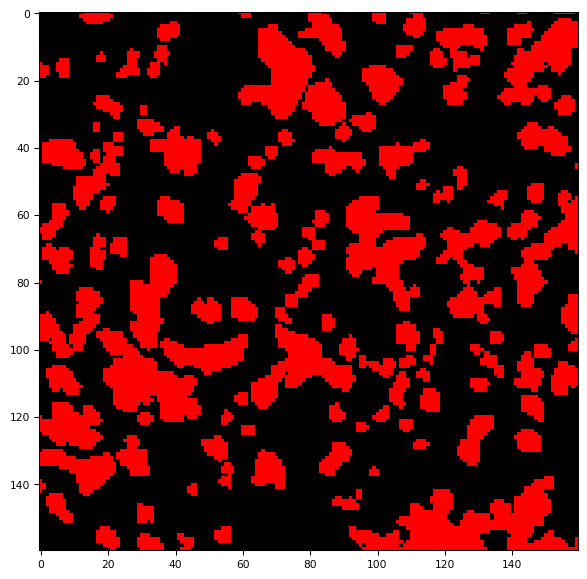

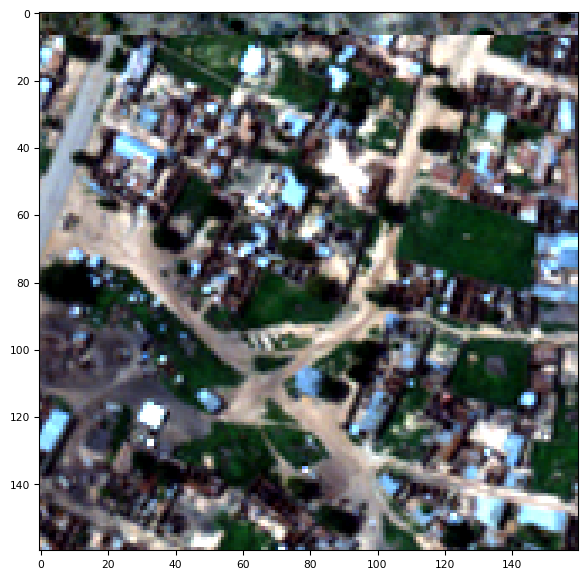

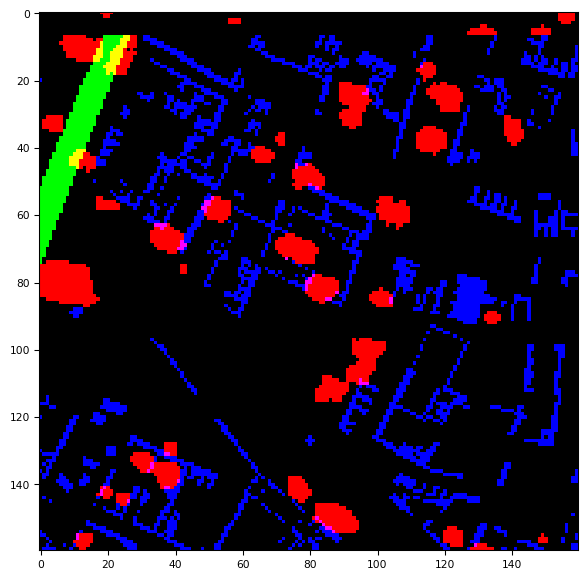

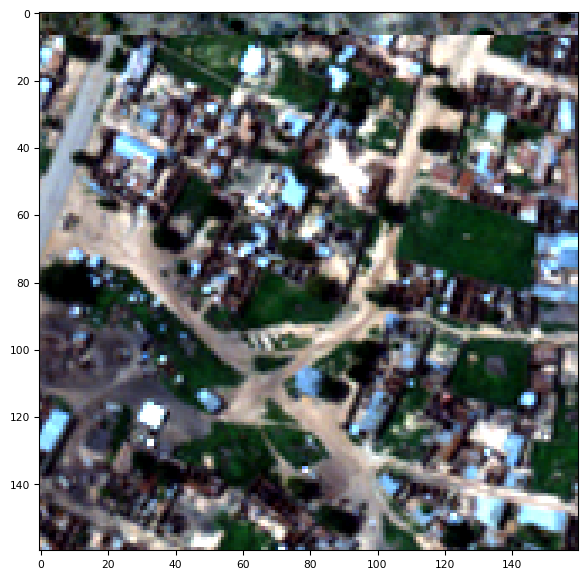

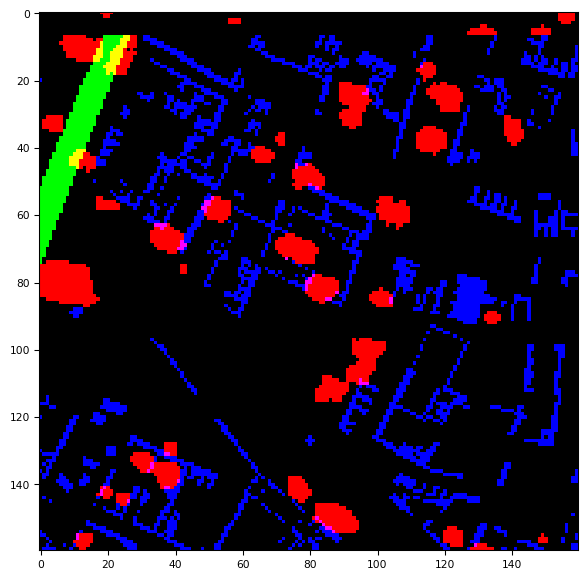

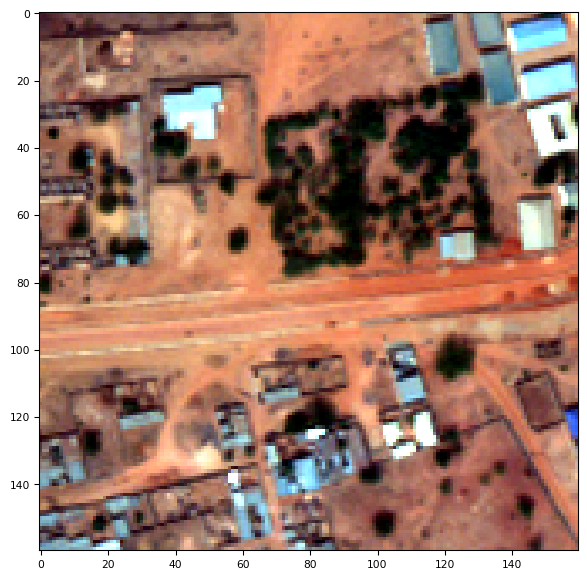

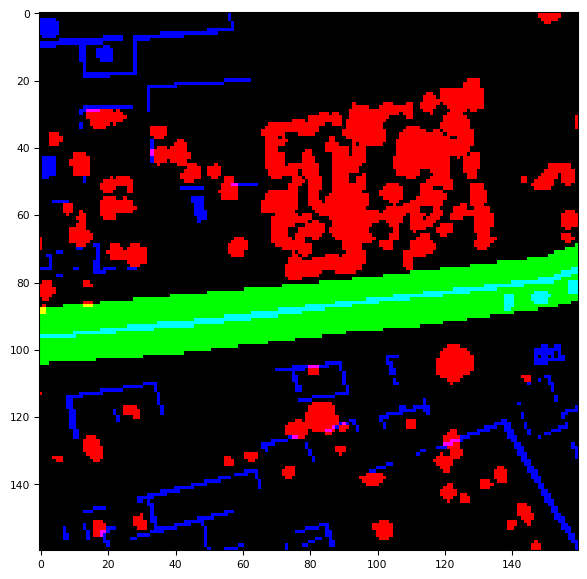

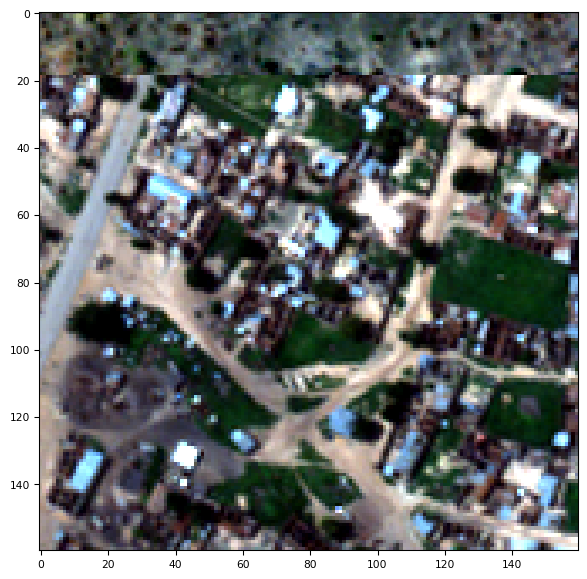

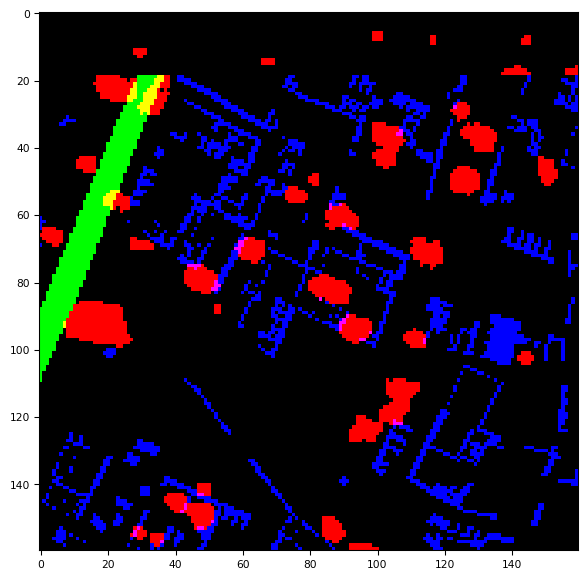

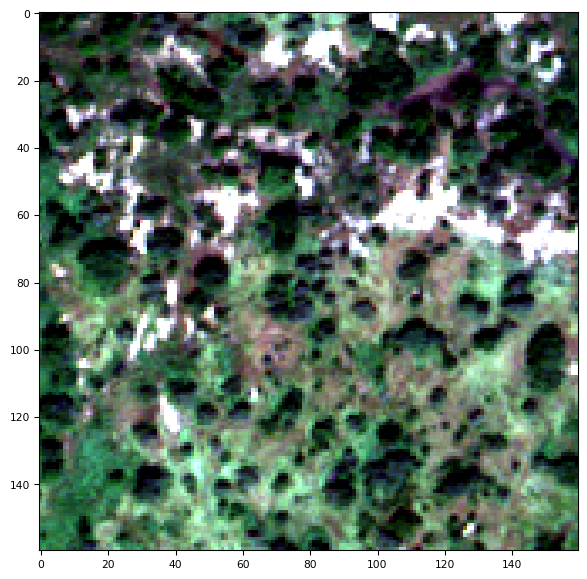

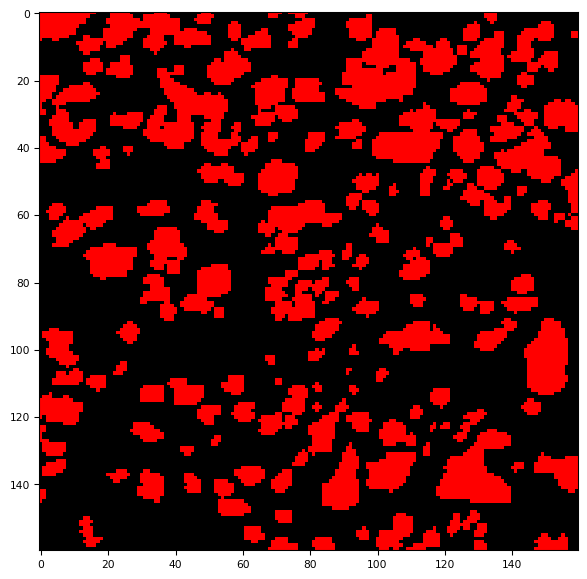

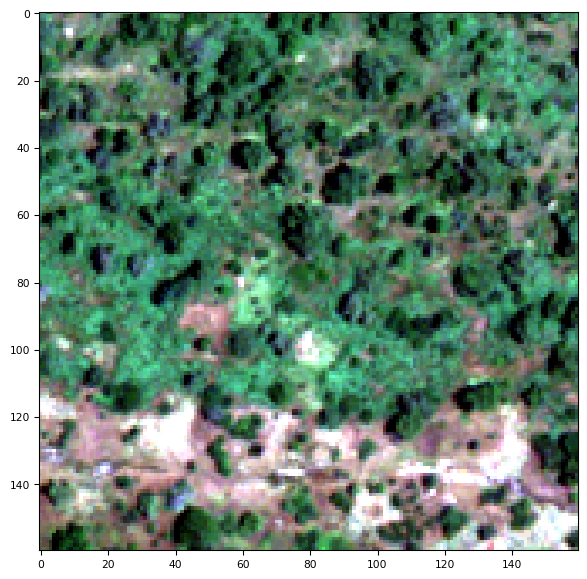

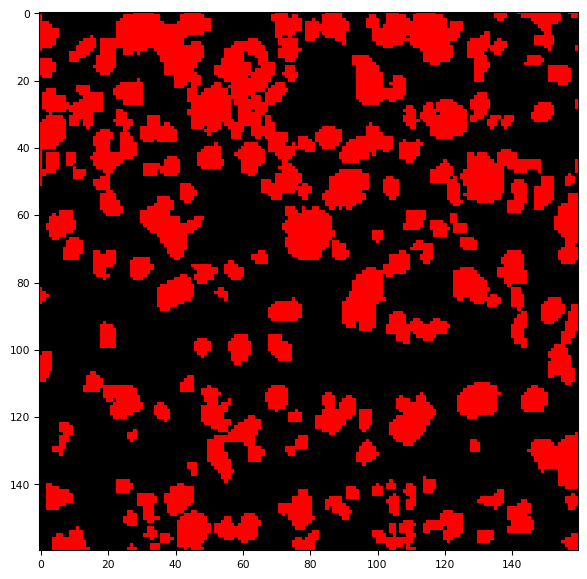

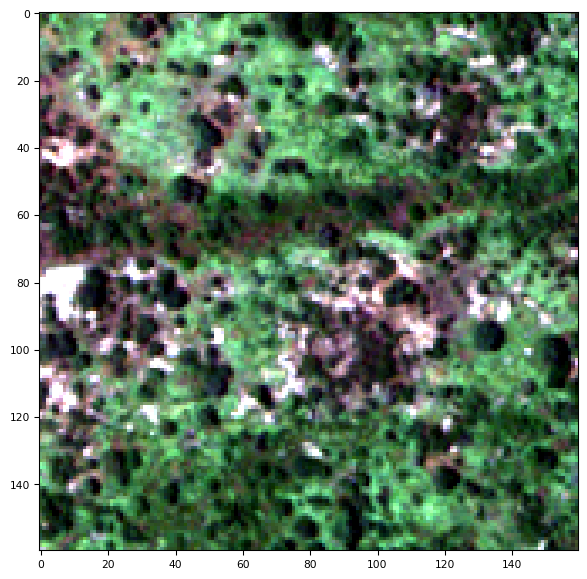

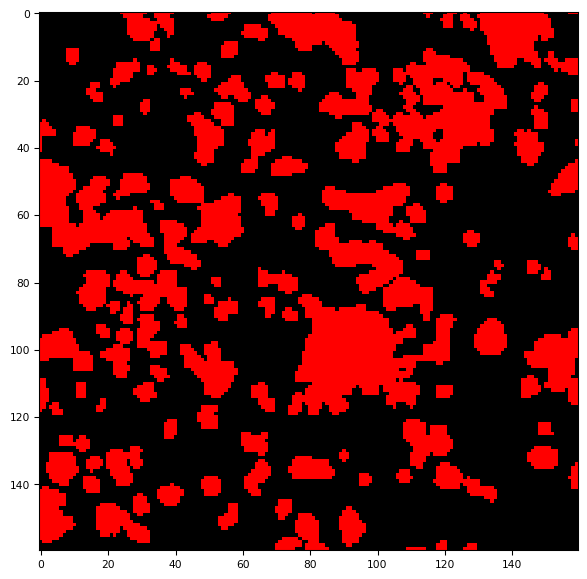

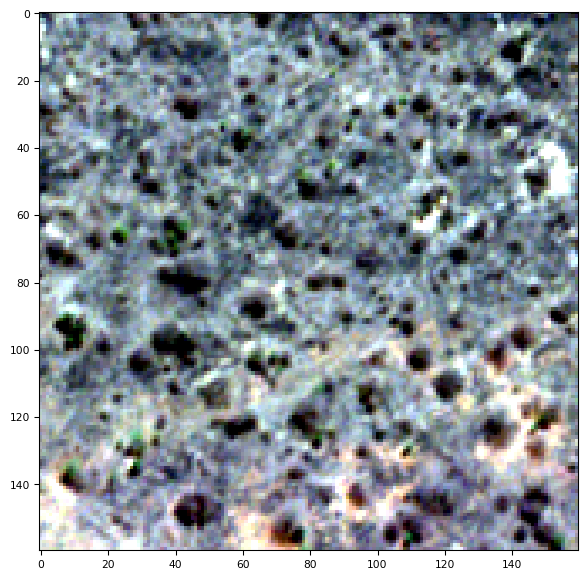

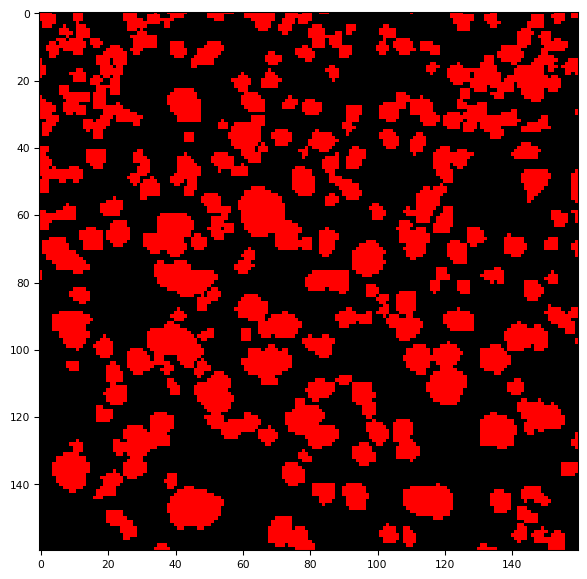

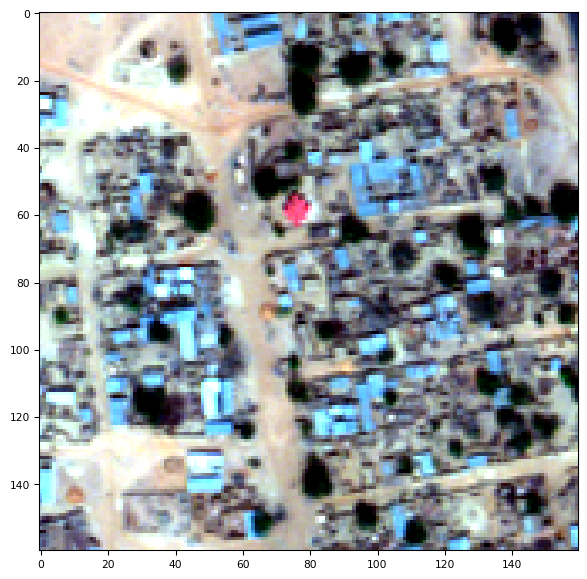

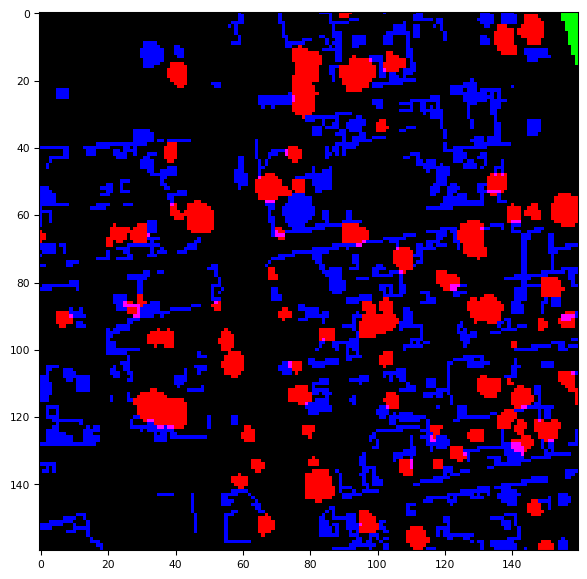

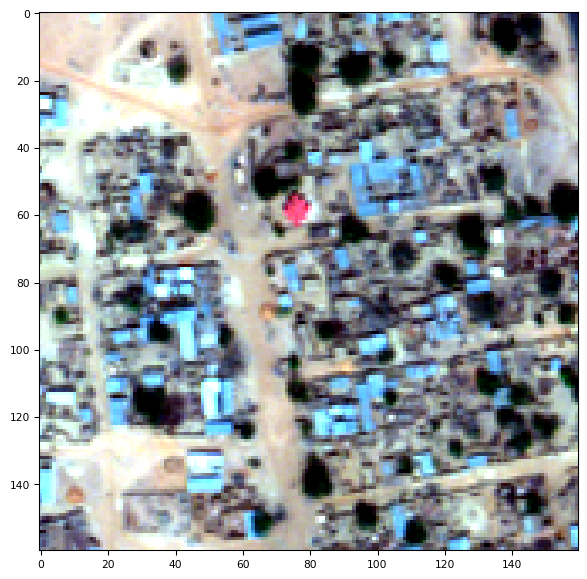

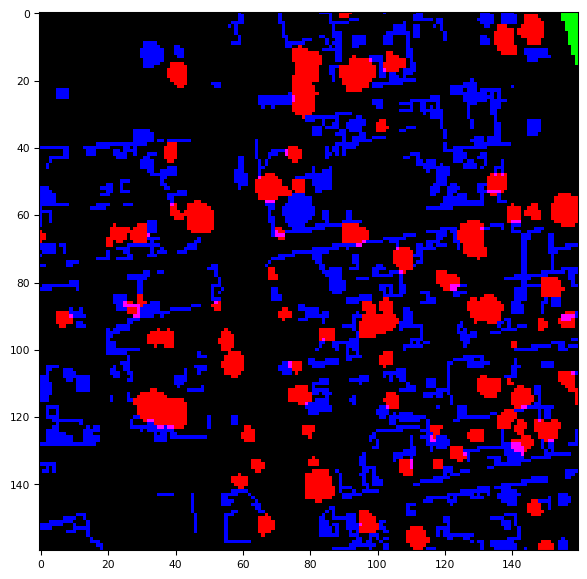

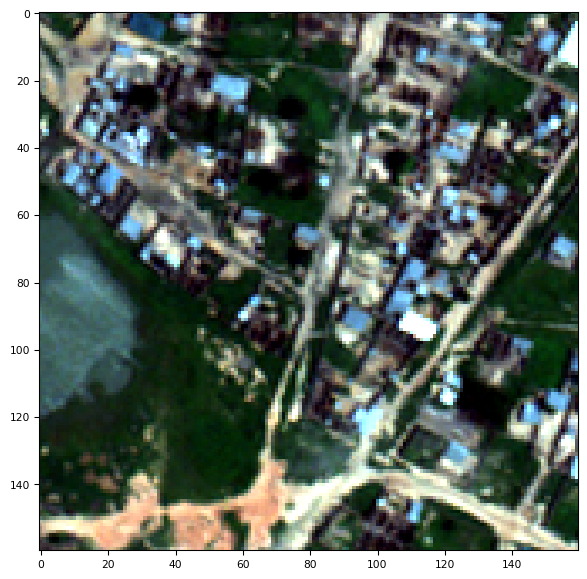

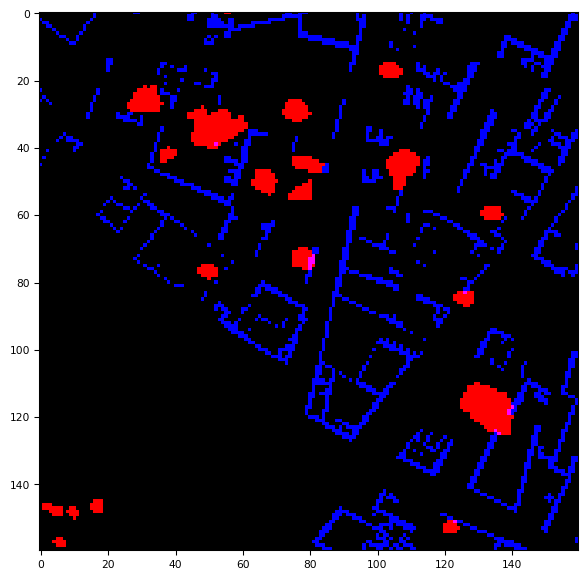

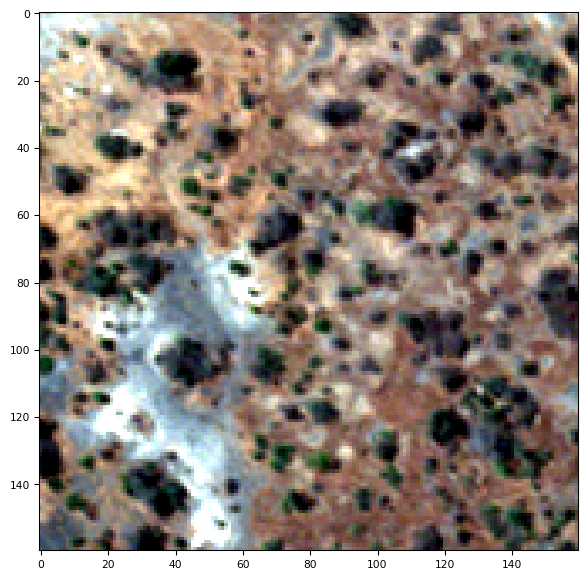

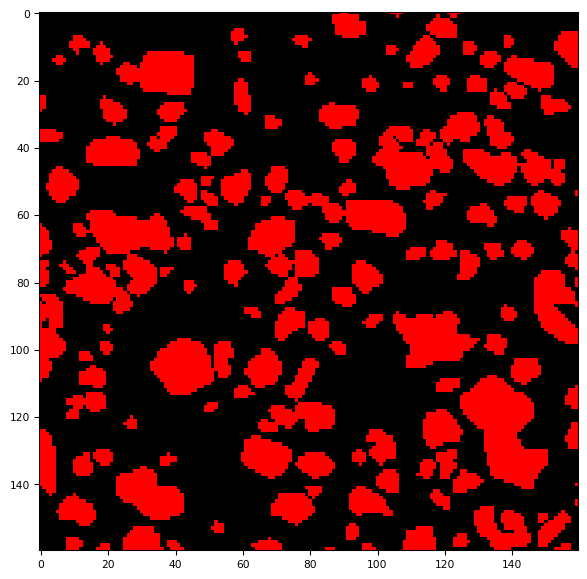

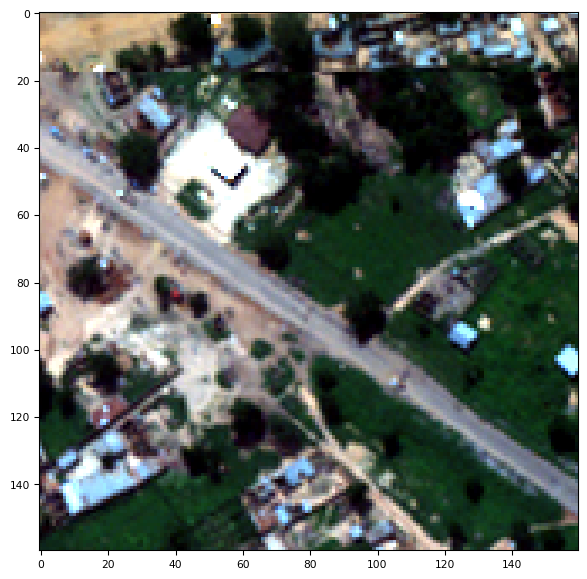

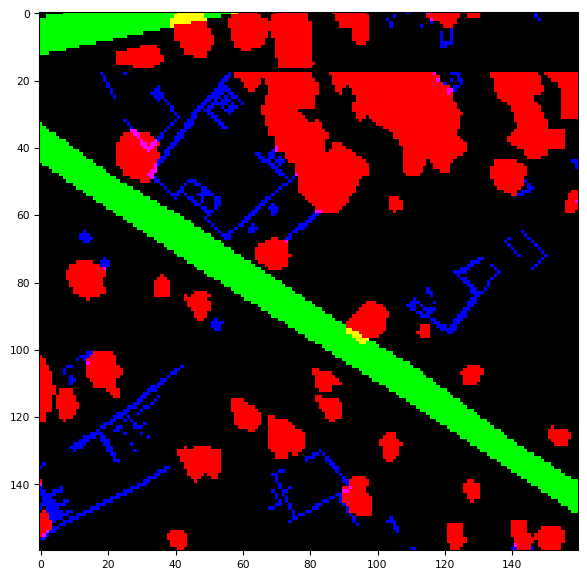

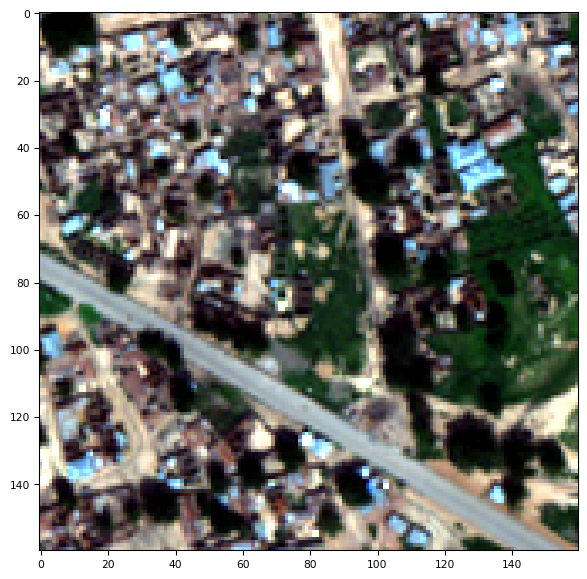

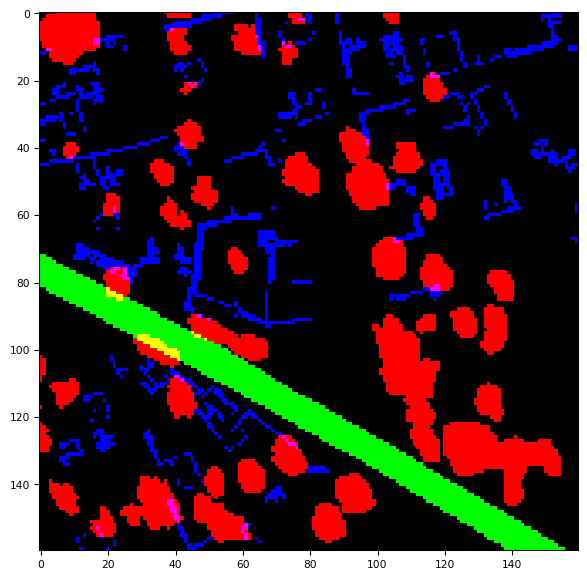

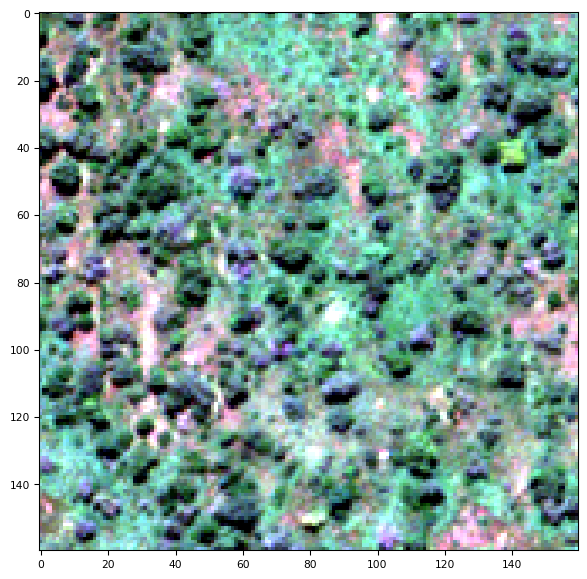

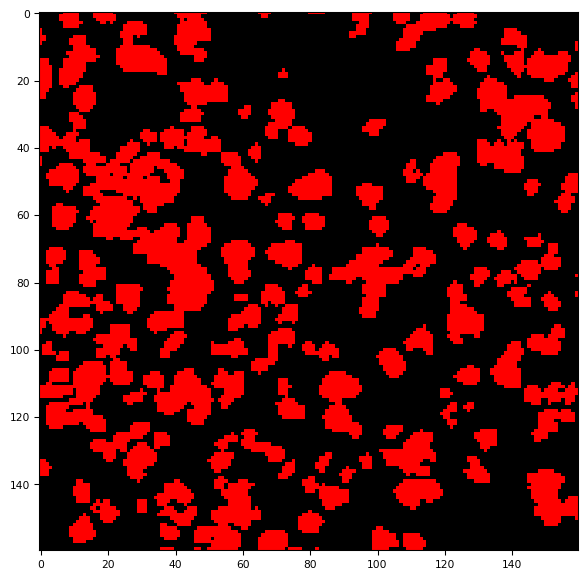

In [65]:
for i in range(50):
   plot_image(i)
   plot_mask(i)